In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from tqdm import tqdm 
import datetime

In [5]:
factor_path = "/Users/shezihua/Documents/MAFM/2022-2023 Summer/MAFS 6100L/SummerIndependentProject/factor/"

futureCodeList = ['JBF', 'QWF', 'HCF', 'DBF', 'EHF', 'IPF', 'IIF', 'QXF', 'PEF', 'NAF']
stockCodeList = ['3443', '2388', '2498', '2610', '1319', '3035', '3006', '2615', '5425', '3105']

data_clean_path = '/Users/shezihua/Documents/MAFM/2022-2023 Summer/MAFS 6100L/SummerIndependentProject/dataCleaned/'

In [36]:
futureCode = futureCodeList[0]
stockCode = stockCodeList[0]

In [37]:
stock = pd.read_csv(data_clean_path + futureCode + "-" + stockCode + "/stock.csv.gz", compression='gzip', index_col=0)
future = pd.read_csv(data_clean_path + futureCode + "-" + stockCode + "/future.csv.gz", compression='gzip', index_col=0)
spread = np.log(stock['price']) - np.log(future['midQ'])
spread = pd.DataFrame(spread)
spread.columns = ['spread']
feature = pd.read_csv(factor_path + futureCode + "-" + stockCode + "/factor.csv.gz", compression='gzip', index_col=0)

In [31]:
pool = pd.DataFrame()
pool.index = stock.index
pool['SP1'] = stock['SP1']
pool['BP1'] = stock['BP1']
pool['askPrice1'] = future['askPrice1']
pool['bidPrice1'] = future['bidPrice1']
pool['spread'] = spread['spread']
pool.index = pd.to_datetime(pool.index)

In [32]:
trade = pd.DataFrame()
trade.index = pool.index
trade['spread'] = pool['spread']
trade['signal'] = 0
trade['cap'] = 0
trade['pnl'] = 0
trade.index = pd.to_datetime(trade.index)

In [33]:
del stock
del future
del spread

# Regression

In [34]:
day_list = np.unique(pool.index.date)
train_period = 3
PnL = np.array([0])

for i in tqdm(range(len(day_list) - train_period)[-30:]):
    train_start_time = trade.index >= pd.to_datetime(str(day_list[i]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period - 1]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train = trade[train_start_time & train_end_time]
    test_start_time = trade.index >= pd.to_datetime(str(day_list[i + train_period]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test = trade[test_start_time & test_end_time]

    feature_train = feature[train_start_time & train_end_time]
    feature_test = feature[test_start_time & test_end_time]

    current_pool = pool[test_start_time & test_end_time]

    mean = np.mean(train['spread'])
    std = np.std(train['spread'])

    upper = mean + 1.5 * std
    lower = mean - 1.5 * std

    X_train = feature_train[feature_train.columns[0:-1]]
    y_train = feature_train['delta_spread']
    upper_quantile=0.85
    lower_quantile=0.15
    train_spread_upper = float(y_train.quantile(upper_quantile))
    train_spread_lower = float(y_train.quantile(lower_quantile))

    model_ols = LinearRegression()
    model_ols.fit(X_train, y_train)
    
    X_test = feature_test[feature_test.columns[0:-1]]
    y_test = feature_test['delta_spread']

    y_test_pred = model_ols.predict(X_test)

    for tick_idx in (range(len(test.index))): 
        current_data = test[0:tick_idx + 1]
        
        if tick_idx != len(test.index) - 2:
            # long spread
            if test.loc[test.index[tick_idx]]['spread'] <= lower: 
                if np.sum(current_data['signal']) == 0: 
                    if y_test_pred[tick_idx] < train_spread_lower:
                        test.at[test.index[tick_idx+1], 'signal'] = 1
                        test.at[test.index[tick_idx+1], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']

            # back to mean
            elif test.loc[test.index[tick_idx]]['spread'] >= mean: 
                if np.sum(current_data['signal']) == 1: 
                    if y_test_pred[tick_idx] > train_spread_upper:
                        test.at[test.index[tick_idx+1], 'signal'] = -1
                        test.at[test.index[tick_idx+1], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                        test.at[test.index[tick_idx+1], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']

            # short spread
            elif test.loc[test.index[tick_idx]]['spread'] >= upper: 
                if np.sum(current_data['signal']) == 0: 
                    if y_test_pred[tick_idx] > train_spread_upper:
                        test.at[test.index[tick_idx+1], 'signal'] = -1
                        test.at[test.index[tick_idx+1], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']

            # back to mean 
            elif test.loc[test.index[tick_idx]]['spread'] <= mean: 
                if np.sum(current_data['signal']) == -1: 
                    if y_test_pred[tick_idx] < train_spread_lower:
                        test.at[test.index[tick_idx+1], 'signal'] = 1
                        test.at[test.index[tick_idx+1], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                        test.at[test.index[tick_idx+1], 'pnl'] = np.sum(current_data['cap'])# + trade.loc[test.index[tick_idx]]['cap']

            else: 
                pass
        
        else:
            pass
            #if np.sum(current_data['signal']) == 1: 
            #    test.at[test.index[tick_idx], 'signal'] = -1
            #    test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
            #    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            #elif np.sum(current_data['signal']) == -1: 
            #    test.at[test.index[tick_idx], 'signal'] = 1
            #    test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
            #    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            #else:
            #    pass
    
    
    PnL = np.append(PnL, test[test['pnl'] != 0]['pnl'] + PnL[-1])

100%|██████████| 30/30 [02:25<00:00,  4.84s/it]


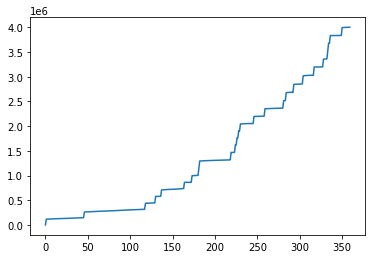

In [35]:
plt.plot(PnL)

# LGBM

In [48]:
pool = pd.DataFrame()
pool.index = stock.index
pool['SP1'] = stock['SP1']
pool['BP1'] = stock['BP1']
pool['askPrice1'] = future['askPrice1']
pool['bidPrice1'] = future['bidPrice1']
pool['spread'] = spread['spread']
pool.index = pd.to_datetime(pool.index)

In [49]:
trade = pd.DataFrame()
trade.index = pool.index
trade['spread'] = pool['spread']
trade['signal'] = 0
trade['cap'] = 0
trade['pnl'] = 0
trade.index = pd.to_datetime(trade.index)

In [50]:
day_list = np.unique(pool.index.date)
train_period = 3
PnL = np.array([0])

for i in tqdm(range(len(day_list) - train_period)[-30:]):
    train_start_time = trade.index >= pd.to_datetime(str(day_list[i]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period - 1]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train = trade[train_start_time & train_end_time]
    test_start_time = trade.index >= pd.to_datetime(str(day_list[i + train_period]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test = trade[test_start_time & test_end_time]

    feature_train = feature[train_start_time & train_end_time]
    feature_test = feature[test_start_time & test_end_time]

    current_pool = pool[test_start_time & test_end_time]

    mean = np.mean(train['spread'])
    std = np.std(train['spread'])

    upper = mean + 1.5 * std
    lower = mean - 1.5 * std

    X_train = feature_train[feature_train.columns[0:-1]]
    y_train = feature_train['delta_spread']
    upper_quantile=0.85
    lower_quantile=0.15
    train_spread_upper = float(y_train.quantile(upper_quantile))
    train_spread_lower = float(y_train.quantile(lower_quantile))

    X_test = feature_test[feature_test.columns[0:-1]]
    y_test = feature_test['delta_spread']


    gbm = lgb.LGBMRegressor(objective='regression',num_leaves=31,learning_rate=0.1,n_estimators=50)
    gbm.fit(X_train, y_train,eval_set=[(X_test, y_test)],eval_metric='l1',early_stopping_rounds=5)

    y_test_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
    

    for tick_idx in (range(len(test.index))): 
        current_data = test[0:tick_idx + 1]
        
        if tick_idx != len(test.index) - 2:
            # long spread
            if test.loc[test.index[tick_idx]]['spread'] <= lower: 
                if np.sum(current_data['signal']) == 0: 
                    if y_test_pred[tick_idx] < train_spread_lower:
                        test.at[test.index[tick_idx+1], 'signal'] = 1
                        test.at[test.index[tick_idx+1], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']

            # back to mean
            elif test.loc[test.index[tick_idx]]['spread'] >= mean: 
                if np.sum(current_data['signal']) == 1: 
                    if y_test_pred[tick_idx] > train_spread_upper:
                        test.at[test.index[tick_idx+1], 'signal'] = -1
                        test.at[test.index[tick_idx+1], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                        test.at[test.index[tick_idx+1], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']

            # short spread
            elif test.loc[test.index[tick_idx]]['spread'] >= upper: 
                if np.sum(current_data['signal']) == 0: 
                    if y_test_pred[tick_idx] > train_spread_upper:
                        test.at[test.index[tick_idx+1], 'signal'] = -1
                        test.at[test.index[tick_idx+1], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']

            # back to mean 
            elif test.loc[test.index[tick_idx]]['spread'] <= mean: 
                if np.sum(current_data['signal']) == -1: 
                    if y_test_pred[tick_idx] < train_spread_lower:
                        test.at[test.index[tick_idx+1], 'signal'] = 1
                        test.at[test.index[tick_idx+1], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                        test.at[test.index[tick_idx+1], 'pnl'] = np.sum(current_data['cap'])# + trade.loc[test.index[tick_idx]]['cap']

            else: 
                pass
        
        else:
            pass
            #if np.sum(current_data['signal']) == 1: 
            #    test.at[test.index[tick_idx], 'signal'] = -1
            #    test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
            #    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            #elif np.sum(current_data['signal']) == -1: 
            #    test.at[test.index[tick_idx], 'signal'] = 1
            #    test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
            #    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            #else:
            #    pass
    
    
    PnL = np.append(PnL, test[test['pnl'] != 0]['pnl'] + PnL[-1])

  0%|          | 0/30 [00:00<?, ?it/s]

[1]	valid_0's l1: 4.33933e-05	valid_0's l2: 1.12148e-07
[2]	valid_0's l1: 3.94643e-05	valid_0's l2: 9.31897e-08
[3]	valid_0's l1: 3.60204e-05	valid_0's l2: 7.81676e-08
[4]	valid_0's l1: 3.27869e-05	valid_0's l2: 6.54437e-08
[5]	valid_0's l1: 2.99161e-05	valid_0's l2: 5.53793e-08
[6]	valid_0's l1: 2.73899e-05	valid_0's l2: 4.74596e-08
[7]	valid_0's l1: 2.51433e-05	valid_0's l2: 4.11464e-08
[8]	valid_0's l1: 2.30479e-05	valid_0's l2: 3.57892e-08
[9]	valid_0's l1: 2.12101e-05	valid_0's l2: 3.15428e-08
[10]	valid_0's l1: 1.95199e-05	valid_0's l2: 2.80344e-08
[11]	valid_0's l1: 1.80009e-05	valid_0's l2: 2.50406e-08
[12]	valid_0's l1: 1.66534e-05	valid_0's l2: 2.27396e-08
[13]	valid_0's l1: 1.53739e-05	valid_0's l2: 2.07059e-08
[14]	valid_0's l1: 1.42436e-05	valid_0's l2: 1.9176e-08
[15]	valid_0's l1: 1.31894e-05	valid_0's l2: 1.78381e-08
[16]	valid_0's l1: 1.23627e-05	valid_0's l2: 1.7027e-08
[17]	valid_0's l1: 1.15244e-05	valid_0's l2: 1.61248e-08
[18]	valid_0's l1: 1.07822e-05	valid_0's l

  3%|▎         | 1/30 [00:05<02:29,  5.15s/it]

[1]	valid_0's l1: 5.30474e-05	valid_0's l2: 1.4224e-07
[2]	valid_0's l1: 4.78703e-05	valid_0's l2: 1.16018e-07
[3]	valid_0's l1: 4.31975e-05	valid_0's l2: 9.45107e-08
[4]	valid_0's l1: 3.9069e-05	valid_0's l2: 7.74568e-08
[5]	valid_0's l1: 3.531e-05	valid_0's l2: 6.33674e-08
[6]	valid_0's l1: 3.19178e-05	valid_0's l2: 5.20225e-08
[7]	valid_0's l1: 2.88557e-05	valid_0's l2: 4.2679e-08
[8]	valid_0's l1: 2.61839e-05	valid_0's l2: 3.5143e-08
[9]	valid_0's l1: 2.37371e-05	valid_0's l2: 2.9125e-08
[10]	valid_0's l1: 2.15958e-05	valid_0's l2: 2.41932e-08
[11]	valid_0's l1: 1.97337e-05	valid_0's l2: 2.03354e-08
[12]	valid_0's l1: 1.78814e-05	valid_0's l2: 1.70014e-08
[13]	valid_0's l1: 1.6272e-05	valid_0's l2: 1.42755e-08
[14]	valid_0's l1: 1.47812e-05	valid_0's l2: 1.20394e-08
[15]	valid_0's l1: 1.33584e-05	valid_0's l2: 1.01496e-08
[16]	valid_0's l1: 1.2108e-05	valid_0's l2: 8.61824e-09
[17]	valid_0's l1: 1.10085e-05	valid_0's l2: 7.41271e-09
[18]	valid_0's l1: 9.94937e-06	valid_0's l2: 6.38

  7%|▋         | 2/30 [00:09<02:17,  4.89s/it]

[1]	valid_0's l1: 7.14417e-05	valid_0's l2: 1.81929e-07
[2]	valid_0's l1: 6.53077e-05	valid_0's l2: 1.52108e-07
[3]	valid_0's l1: 5.93694e-05	valid_0's l2: 1.2655e-07
[4]	valid_0's l1: 5.42795e-05	valid_0's l2: 1.07292e-07
[5]	valid_0's l1: 5.04776e-05	valid_0's l2: 9.46355e-08
[6]	valid_0's l1: 4.70982e-05	valid_0's l2: 8.50695e-08
[7]	valid_0's l1: 4.31552e-05	valid_0's l2: 7.22843e-08
[8]	valid_0's l1: 4.0707e-05	valid_0's l2: 6.5706e-08
[9]	valid_0's l1: 3.88017e-05	valid_0's l2: 6.14755e-08
[10]	valid_0's l1: 3.62414e-05	valid_0's l2: 5.49279e-08
[11]	valid_0's l1: 3.44485e-05	valid_0's l2: 5.18476e-08
[12]	valid_0's l1: 3.28095e-05	valid_0's l2: 4.90582e-08
[13]	valid_0's l1: 3.13365e-05	valid_0's l2: 4.73816e-08
[14]	valid_0's l1: 2.94163e-05	valid_0's l2: 4.35289e-08
[15]	valid_0's l1: 2.82033e-05	valid_0's l2: 4.256e-08
[16]	valid_0's l1: 2.72888e-05	valid_0's l2: 4.21359e-08
[17]	valid_0's l1: 2.62168e-05	valid_0's l2: 4.15033e-08
[18]	valid_0's l1: 2.52428e-05	valid_0's l2: 

 10%|█         | 3/30 [00:15<02:24,  5.34s/it]

[1]	valid_0's l1: 7.11989e-05	valid_0's l2: 1.75437e-07
[2]	valid_0's l1: 6.43109e-05	valid_0's l2: 1.44616e-07
[3]	valid_0's l1: 5.80328e-05	valid_0's l2: 1.20194e-07
[4]	valid_0's l1: 5.21997e-05	valid_0's l2: 1.00669e-07
[5]	valid_0's l1: 4.68481e-05	valid_0's l2: 8.46488e-08
[6]	valid_0's l1: 4.19279e-05	valid_0's l2: 7.2485e-08
[7]	valid_0's l1: 3.90648e-05	valid_0's l2: 6.33428e-08
[8]	valid_0's l1: 3.68339e-05	valid_0's l2: 5.64739e-08
[9]	valid_0's l1: 3.46438e-05	valid_0's l2: 5.0947e-08
[10]	valid_0's l1: 3.29356e-05	valid_0's l2: 4.69907e-08
[11]	valid_0's l1: 3.12535e-05	valid_0's l2: 4.37897e-08
[12]	valid_0's l1: 2.97097e-05	valid_0's l2: 4.15277e-08
[13]	valid_0's l1: 2.84833e-05	valid_0's l2: 3.9966e-08
[14]	valid_0's l1: 2.72873e-05	valid_0's l2: 3.90916e-08
[15]	valid_0's l1: 2.62774e-05	valid_0's l2: 3.83175e-08
[16]	valid_0's l1: 2.52392e-05	valid_0's l2: 3.78487e-08
[17]	valid_0's l1: 2.44984e-05	valid_0's l2: 3.78249e-08
[18]	valid_0's l1: 2.3707e-05	valid_0's l2:

 13%|█▎        | 4/30 [00:23<02:41,  6.20s/it]

[1]	valid_0's l1: 8.8058e-05	valid_0's l2: 2.03072e-07
[2]	valid_0's l1: 7.94521e-05	valid_0's l2: 1.65678e-07
[3]	valid_0's l1: 7.20323e-05	valid_0's l2: 1.37067e-07
[4]	valid_0's l1: 6.51065e-05	valid_0's l2: 1.13512e-07
[5]	valid_0's l1: 5.92502e-05	valid_0's l2: 9.61044e-08
[6]	valid_0's l1: 5.40099e-05	valid_0's l2: 8.12883e-08
[7]	valid_0's l1: 4.96627e-05	valid_0's l2: 6.97306e-08
[8]	valid_0's l1: 4.57718e-05	valid_0's l2: 6.07176e-08
[9]	valid_0's l1: 4.22464e-05	valid_0's l2: 5.33765e-08
[10]	valid_0's l1: 3.91437e-05	valid_0's l2: 4.78481e-08
[11]	valid_0's l1: 3.62561e-05	valid_0's l2: 4.32899e-08
[12]	valid_0's l1: 3.35859e-05	valid_0's l2: 3.96643e-08
[13]	valid_0's l1: 3.11594e-05	valid_0's l2: 3.66631e-08
[14]	valid_0's l1: 2.89306e-05	valid_0's l2: 3.45004e-08
[15]	valid_0's l1: 2.69575e-05	valid_0's l2: 3.3114e-08
[16]	valid_0's l1: 2.53441e-05	valid_0's l2: 3.1865e-08
[17]	valid_0's l1: 2.42605e-05	valid_0's l2: 3.12172e-08
[18]	valid_0's l1: 2.33082e-05	valid_0's l2

 17%|█▋        | 5/30 [00:30<02:45,  6.62s/it]

[1]	valid_0's l1: 6.58497e-05	valid_0's l2: 1.49304e-07
[2]	valid_0's l1: 5.989e-05	valid_0's l2: 1.23865e-07
[3]	valid_0's l1: 5.47288e-05	valid_0's l2: 1.04118e-07
[4]	valid_0's l1: 4.99165e-05	valid_0's l2: 8.76965e-08
[5]	valid_0's l1: 4.55699e-05	valid_0's l2: 7.44529e-08
[6]	valid_0's l1: 4.172e-05	valid_0's l2: 6.40657e-08
[7]	valid_0's l1: 3.8168e-05	valid_0's l2: 5.54175e-08
[8]	valid_0's l1: 3.50064e-05	valid_0's l2: 4.87397e-08
[9]	valid_0's l1: 3.19811e-05	valid_0's l2: 4.2839e-08
[10]	valid_0's l1: 2.94276e-05	valid_0's l2: 3.84989e-08
[11]	valid_0's l1: 2.7415e-05	valid_0's l2: 3.51613e-08
[12]	valid_0's l1: 2.53122e-05	valid_0's l2: 3.23062e-08
[13]	valid_0's l1: 2.3343e-05	valid_0's l2: 2.93482e-08
[14]	valid_0's l1: 2.17091e-05	valid_0's l2: 2.70935e-08
[15]	valid_0's l1: 2.03461e-05	valid_0's l2: 2.52734e-08
[16]	valid_0's l1: 1.89638e-05	valid_0's l2: 2.38625e-08
[17]	valid_0's l1: 1.77336e-05	valid_0's l2: 2.26445e-08
[18]	valid_0's l1: 1.65505e-05	valid_0's l2: 2.1

 20%|██        | 6/30 [00:38<02:46,  6.92s/it]

[1]	valid_0's l1: 5.87157e-05	valid_0's l2: 1.35134e-07
[2]	valid_0's l1: 5.32774e-05	valid_0's l2: 1.11561e-07
[3]	valid_0's l1: 4.844e-05	valid_0's l2: 9.25914e-08
[4]	valid_0's l1: 4.39995e-05	valid_0's l2: 7.68878e-08
[5]	valid_0's l1: 4.00358e-05	valid_0's l2: 6.42248e-08
[6]	valid_0's l1: 3.64548e-05	valid_0's l2: 5.39179e-08
[7]	valid_0's l1: 3.32629e-05	valid_0's l2: 4.56495e-08
[8]	valid_0's l1: 3.0383e-05	valid_0's l2: 3.88213e-08
[9]	valid_0's l1: 2.76796e-05	valid_0's l2: 3.30397e-08
[10]	valid_0's l1: 2.53551e-05	valid_0's l2: 2.86261e-08
[11]	valid_0's l1: 2.31729e-05	valid_0's l2: 2.46716e-08
[12]	valid_0's l1: 2.13019e-05	valid_0's l2: 2.17118e-08
[13]	valid_0's l1: 1.95157e-05	valid_0's l2: 1.91468e-08
[14]	valid_0's l1: 1.79208e-05	valid_0's l2: 1.70503e-08
[15]	valid_0's l1: 1.64921e-05	valid_0's l2: 1.53144e-08
[16]	valid_0's l1: 1.52187e-05	valid_0's l2: 1.38422e-08
[17]	valid_0's l1: 1.41168e-05	valid_0's l2: 1.27788e-08
[18]	valid_0's l1: 1.30222e-05	valid_0's l2

 23%|██▎       | 7/30 [00:44<02:34,  6.73s/it]

[1]	valid_0's l1: 0.000108333	valid_0's l2: 2.38752e-07
[2]	valid_0's l1: 9.7118e-05	valid_0's l2: 1.96509e-07
[3]	valid_0's l1: 8.71067e-05	valid_0's l2: 1.64483e-07
[4]	valid_0's l1: 7.7915e-05	valid_0's l2: 1.39698e-07
[5]	valid_0's l1: 6.97756e-05	valid_0's l2: 1.21605e-07
[6]	valid_0's l1: 6.2417e-05	valid_0's l2: 1.07648e-07
[7]	valid_0's l1: 6.00688e-05	valid_0's l2: 9.82312e-08
[8]	valid_0's l1: 5.79611e-05	valid_0's l2: 9.0691e-08
[9]	valid_0's l1: 5.64361e-05	valid_0's l2: 8.64516e-08
[10]	valid_0's l1: 5.47626e-05	valid_0's l2: 8.31971e-08
[11]	valid_0's l1: 5.35333e-05	valid_0's l2: 8.17994e-08
[12]	valid_0's l1: 5.22814e-05	valid_0's l2: 8.10309e-08
[13]	valid_0's l1: 5.1296e-05	valid_0's l2: 8.17097e-08
[14]	valid_0's l1: 5.02334e-05	valid_0's l2: 8.17438e-08
[15]	valid_0's l1: 4.93009e-05	valid_0's l2: 8.2638e-08
[16]	valid_0's l1: 4.83793e-05	valid_0's l2: 8.31373e-08
[17]	valid_0's l1: 4.72322e-05	valid_0's l2: 8.30817e-08


 27%|██▋       | 8/30 [00:48<02:07,  5.80s/it]

[1]	valid_0's l1: 8.11956e-05	valid_0's l2: 1.81186e-07
[2]	valid_0's l1: 7.2326e-05	valid_0's l2: 1.47629e-07
[3]	valid_0's l1: 6.48209e-05	valid_0's l2: 1.2269e-07
[4]	valid_0's l1: 5.79151e-05	valid_0's l2: 1.03505e-07
[5]	valid_0's l1: 5.12199e-05	valid_0's l2: 8.75746e-08
[6]	valid_0's l1: 4.629e-05	valid_0's l2: 7.59941e-08
[7]	valid_0's l1: 4.36968e-05	valid_0's l2: 6.69781e-08
[8]	valid_0's l1: 4.19826e-05	valid_0's l2: 6.13234e-08
[9]	valid_0's l1: 4.03345e-05	valid_0's l2: 5.66593e-08
[10]	valid_0's l1: 3.8784e-05	valid_0's l2: 5.33911e-08
[11]	valid_0's l1: 3.70995e-05	valid_0's l2: 5.08054e-08
[12]	valid_0's l1: 3.60557e-05	valid_0's l2: 4.95761e-08
[13]	valid_0's l1: 3.51045e-05	valid_0's l2: 4.9038e-08
[14]	valid_0's l1: 3.40206e-05	valid_0's l2: 4.84801e-08
[15]	valid_0's l1: 3.31154e-05	valid_0's l2: 4.86382e-08
[16]	valid_0's l1: 3.27665e-05	valid_0's l2: 4.95508e-08
[17]	valid_0's l1: 3.22199e-05	valid_0's l2: 5.0189e-08
[18]	valid_0's l1: 3.21778e-05	valid_0's l2: 5.

 30%|███       | 9/30 [00:56<02:15,  6.46s/it]

[1]	valid_0's l1: 8.9291e-05	valid_0's l2: 1.76102e-07
[2]	valid_0's l1: 8.00663e-05	valid_0's l2: 1.42509e-07
[3]	valid_0's l1: 7.16934e-05	valid_0's l2: 1.15845e-07
[4]	valid_0's l1: 6.41471e-05	valid_0's l2: 9.48744e-08
[5]	valid_0's l1: 5.72689e-05	valid_0's l2: 7.82468e-08
[6]	valid_0's l1: 5.1435e-05	valid_0's l2: 6.60217e-08
[7]	valid_0's l1: 4.68748e-05	valid_0's l2: 5.59061e-08
[8]	valid_0's l1: 4.29901e-05	valid_0's l2: 4.82319e-08
[9]	valid_0's l1: 3.94362e-05	valid_0's l2: 4.21331e-08
[10]	valid_0's l1: 3.642e-05	valid_0's l2: 3.77572e-08
[11]	valid_0's l1: 3.37012e-05	valid_0's l2: 3.42989e-08
[12]	valid_0's l1: 3.12338e-05	valid_0's l2: 3.16093e-08
[13]	valid_0's l1: 2.87588e-05	valid_0's l2: 2.92554e-08
[14]	valid_0's l1: 2.66198e-05	valid_0's l2: 2.74947e-08
[15]	valid_0's l1: 2.50317e-05	valid_0's l2: 2.69505e-08
[16]	valid_0's l1: 2.35579e-05	valid_0's l2: 2.6078e-08
[17]	valid_0's l1: 2.20668e-05	valid_0's l2: 2.52687e-08
[18]	valid_0's l1: 2.07611e-05	valid_0's l2: 

 33%|███▎      | 10/30 [01:04<02:20,  7.04s/it]

[1]	valid_0's l1: 0.000131574	valid_0's l2: 2.52358e-07
[2]	valid_0's l1: 0.000119811	valid_0's l2: 2.093e-07
[3]	valid_0's l1: 0.000109127	valid_0's l2: 1.74446e-07
[4]	valid_0's l1: 9.9391e-05	valid_0's l2: 1.46032e-07
[5]	valid_0's l1: 9.03884e-05	valid_0's l2: 1.22327e-07
[6]	valid_0's l1: 8.26118e-05	valid_0's l2: 1.03988e-07
[7]	valid_0's l1: 7.52824e-05	valid_0's l2: 8.85775e-08
[8]	valid_0's l1: 6.88067e-05	valid_0's l2: 7.61396e-08
[9]	valid_0's l1: 6.29343e-05	valid_0's l2: 6.6277e-08
[10]	valid_0's l1: 5.7727e-05	valid_0's l2: 5.85476e-08
[11]	valid_0's l1: 5.31373e-05	valid_0's l2: 5.24947e-08
[12]	valid_0's l1: 4.89305e-05	valid_0's l2: 4.73031e-08
[13]	valid_0's l1: 4.4966e-05	valid_0's l2: 4.26291e-08
[14]	valid_0's l1: 4.14408e-05	valid_0's l2: 3.89374e-08
[15]	valid_0's l1: 3.82777e-05	valid_0's l2: 3.58365e-08
[16]	valid_0's l1: 3.52635e-05	valid_0's l2: 3.33639e-08
[17]	valid_0's l1: 3.27114e-05	valid_0's l2: 3.1456e-08
[18]	valid_0's l1: 3.055e-05	valid_0's l2: 2.99

 37%|███▋      | 11/30 [01:08<01:54,  6.04s/it]

[1]	valid_0's l1: 8.03995e-05	valid_0's l2: 1.70082e-07
[2]	valid_0's l1: 7.32866e-05	valid_0's l2: 1.41502e-07
[3]	valid_0's l1: 6.68766e-05	valid_0's l2: 1.18589e-07
[4]	valid_0's l1: 6.10913e-05	valid_0's l2: 1.00255e-07
[5]	valid_0's l1: 5.57698e-05	valid_0's l2: 8.48694e-08
[6]	valid_0's l1: 5.09369e-05	valid_0's l2: 7.23801e-08
[7]	valid_0's l1: 4.6796e-05	valid_0's l2: 6.30863e-08
[8]	valid_0's l1: 4.31138e-05	valid_0's l2: 5.55735e-08
[9]	valid_0's l1: 3.97603e-05	valid_0's l2: 4.9294e-08
[10]	valid_0's l1: 3.68254e-05	valid_0's l2: 4.46381e-08
[11]	valid_0's l1: 3.41257e-05	valid_0's l2: 4.07996e-08
[12]	valid_0's l1: 3.16851e-05	valid_0's l2: 3.77279e-08
[13]	valid_0's l1: 2.94805e-05	valid_0's l2: 3.55145e-08
[14]	valid_0's l1: 2.74349e-05	valid_0's l2: 3.35066e-08
[15]	valid_0's l1: 2.55248e-05	valid_0's l2: 3.15469e-08
[16]	valid_0's l1: 2.37839e-05	valid_0's l2: 2.98593e-08
[17]	valid_0's l1: 2.22235e-05	valid_0's l2: 2.86464e-08
[18]	valid_0's l1: 2.07713e-05	valid_0's l

 40%|████      | 12/30 [01:12<01:39,  5.51s/it]

[1]	valid_0's l1: 0.000193066	valid_0's l2: 4.08543e-07
[2]	valid_0's l1: 0.000181104	valid_0's l2: 3.57817e-07
[3]	valid_0's l1: 0.000170091	valid_0's l2: 3.17016e-07
[4]	valid_0's l1: 0.000159845	valid_0's l2: 2.83713e-07
[5]	valid_0's l1: 0.000151041	valid_0's l2: 2.58748e-07
[6]	valid_0's l1: 0.000142894	valid_0's l2: 2.38993e-07
[7]	valid_0's l1: 0.000135839	valid_0's l2: 2.22737e-07
[8]	valid_0's l1: 0.000129818	valid_0's l2: 2.08374e-07
[9]	valid_0's l1: 0.000124524	valid_0's l2: 1.97295e-07
[10]	valid_0's l1: 0.000119455	valid_0's l2: 1.88101e-07
[11]	valid_0's l1: 0.000114885	valid_0's l2: 1.80587e-07
[12]	valid_0's l1: 0.000110625	valid_0's l2: 1.73589e-07
[13]	valid_0's l1: 0.000106817	valid_0's l2: 1.68084e-07
[14]	valid_0's l1: 0.00010349	valid_0's l2: 1.64243e-07
[15]	valid_0's l1: 0.000100636	valid_0's l2: 1.61135e-07
[16]	valid_0's l1: 9.81796e-05	valid_0's l2: 1.60438e-07
[17]	valid_0's l1: 9.52342e-05	valid_0's l2: 1.57234e-07
[18]	valid_0's l1: 9.34121e-05	valid_0's 

 43%|████▎     | 13/30 [01:13<01:09,  4.10s/it]

[1]	valid_0's l1: 8.87926e-05	valid_0's l2: 1.77254e-07
[2]	valid_0's l1: 8.18375e-05	valid_0's l2: 1.51744e-07
[3]	valid_0's l1: 7.5613e-05	valid_0's l2: 1.3144e-07
[4]	valid_0's l1: 6.97772e-05	valid_0's l2: 1.13707e-07
[5]	valid_0's l1: 6.48133e-05	valid_0's l2: 9.99831e-08
[6]	valid_0's l1: 6.0393e-05	valid_0's l2: 8.91419e-08
[7]	valid_0's l1: 5.60717e-05	valid_0's l2: 7.9138e-08
[8]	valid_0's l1: 5.25158e-05	valid_0's l2: 7.19198e-08
[9]	valid_0's l1: 4.90463e-05	valid_0's l2: 6.53724e-08
[10]	valid_0's l1: 4.60941e-05	valid_0's l2: 6.04783e-08
[11]	valid_0's l1: 4.31749e-05	valid_0's l2: 5.58114e-08
[12]	valid_0's l1: 4.07691e-05	valid_0's l2: 5.25972e-08
[13]	valid_0's l1: 3.8413e-05	valid_0's l2: 4.94191e-08
[14]	valid_0's l1: 3.66387e-05	valid_0's l2: 4.68775e-08
[15]	valid_0's l1: 3.46185e-05	valid_0's l2: 4.46378e-08
[16]	valid_0's l1: 3.30021e-05	valid_0's l2: 4.3307e-08
[17]	valid_0's l1: 3.17928e-05	valid_0's l2: 4.22761e-08
[18]	valid_0's l1: 3.00736e-05	valid_0's l2: 4

 47%|████▋     | 14/30 [01:18<01:11,  4.48s/it]

[1]	valid_0's l1: 0.000104402	valid_0's l2: 2.14663e-07
[2]	valid_0's l1: 9.59518e-05	valid_0's l2: 1.8124e-07
[3]	valid_0's l1: 8.85249e-05	valid_0's l2: 1.54574e-07
[4]	valid_0's l1: 8.13374e-05	valid_0's l2: 1.31353e-07
[5]	valid_0's l1: 7.53092e-05	valid_0's l2: 1.13648e-07
[6]	valid_0's l1: 6.95428e-05	valid_0's l2: 9.83452e-08
[7]	valid_0's l1: 6.43384e-05	valid_0's l2: 8.58543e-08
[8]	valid_0's l1: 5.96784e-05	valid_0's l2: 7.53155e-08
[9]	valid_0's l1: 5.55287e-05	valid_0's l2: 6.69903e-08
[10]	valid_0's l1: 5.15481e-05	valid_0's l2: 5.97736e-08
[11]	valid_0's l1: 4.80873e-05	valid_0's l2: 5.40437e-08
[12]	valid_0's l1: 4.4999e-05	valid_0's l2: 4.92322e-08
[13]	valid_0's l1: 4.21764e-05	valid_0's l2: 4.52575e-08
[14]	valid_0's l1: 4.06611e-05	valid_0's l2: 4.27453e-08
[15]	valid_0's l1: 3.8441e-05	valid_0's l2: 3.98805e-08
[16]	valid_0's l1: 3.7065e-05	valid_0's l2: 3.79812e-08
[17]	valid_0's l1: 3.53196e-05	valid_0's l2: 3.60753e-08
[18]	valid_0's l1: 3.42409e-05	valid_0's l2:

 50%|█████     | 15/30 [01:23<01:08,  4.59s/it]

[1]	valid_0's l1: 9.55951e-05	valid_0's l2: 2.00594e-07
[2]	valid_0's l1: 8.80324e-05	valid_0's l2: 1.69662e-07
[3]	valid_0's l1: 8.12435e-05	valid_0's l2: 1.44639e-07
[4]	valid_0's l1: 7.5318e-05	valid_0's l2: 1.24793e-07
[5]	valid_0's l1: 6.97167e-05	valid_0's l2: 1.07872e-07
[6]	valid_0's l1: 6.47226e-05	valid_0's l2: 9.42596e-08
[7]	valid_0's l1: 6.0107e-05	valid_0's l2: 8.27554e-08
[8]	valid_0's l1: 5.59193e-05	valid_0's l2: 7.30621e-08
[9]	valid_0's l1: 5.21319e-05	valid_0's l2: 6.51258e-08
[10]	valid_0's l1: 4.87966e-05	valid_0's l2: 5.88778e-08
[11]	valid_0's l1: 4.57936e-05	valid_0's l2: 5.36959e-08
[12]	valid_0's l1: 4.30127e-05	valid_0's l2: 4.91507e-08
[13]	valid_0's l1: 4.06458e-05	valid_0's l2: 4.56586e-08
[14]	valid_0's l1: 3.83965e-05	valid_0's l2: 4.2744e-08
[15]	valid_0's l1: 3.61638e-05	valid_0's l2: 3.9588e-08
[16]	valid_0's l1: 3.42862e-05	valid_0's l2: 3.74384e-08
[17]	valid_0's l1: 3.2408e-05	valid_0's l2: 3.49602e-08
[18]	valid_0's l1: 3.08802e-05	valid_0's l2: 

 53%|█████▎    | 16/30 [01:29<01:10,  5.05s/it]

[1]	valid_0's l1: 9.41169e-05	valid_0's l2: 1.84892e-07
[2]	valid_0's l1: 8.57565e-05	valid_0's l2: 1.53771e-07
[3]	valid_0's l1: 7.84467e-05	valid_0's l2: 1.29015e-07
[4]	valid_0's l1: 7.2054e-05	valid_0's l2: 1.09398e-07
[5]	valid_0's l1: 6.63367e-05	valid_0's l2: 9.35905e-08
[6]	valid_0's l1: 6.10208e-05	valid_0's l2: 8.01841e-08
[7]	valid_0's l1: 5.62472e-05	valid_0's l2: 6.93472e-08
[8]	valid_0's l1: 5.1775e-05	valid_0's l2: 6.01159e-08
[9]	valid_0's l1: 4.80323e-05	valid_0's l2: 5.29022e-08
[10]	valid_0's l1: 4.45551e-05	valid_0's l2: 4.69252e-08
[11]	valid_0's l1: 4.13309e-05	valid_0's l2: 4.17196e-08
[12]	valid_0's l1: 3.83999e-05	valid_0's l2: 3.74782e-08
[13]	valid_0's l1: 3.56416e-05	valid_0's l2: 3.38993e-08
[14]	valid_0's l1: 3.32521e-05	valid_0's l2: 3.07985e-08
[15]	valid_0's l1: 3.09649e-05	valid_0's l2: 2.82138e-08
[16]	valid_0's l1: 2.95277e-05	valid_0's l2: 2.65904e-08
[17]	valid_0's l1: 2.76633e-05	valid_0's l2: 2.47809e-08
[18]	valid_0's l1: 2.58991e-05	valid_0's l

 57%|█████▋    | 17/30 [01:34<01:03,  4.92s/it]

[1]	valid_0's l1: 8.37713e-05	valid_0's l2: 1.68785e-07
[2]	valid_0's l1: 7.63799e-05	valid_0's l2: 1.40354e-07
[3]	valid_0's l1: 6.96093e-05	valid_0's l2: 1.16976e-07
[4]	valid_0's l1: 6.36459e-05	valid_0's l2: 9.84924e-08
[5]	valid_0's l1: 5.82667e-05	valid_0's l2: 8.341e-08
[6]	valid_0's l1: 5.31813e-05	valid_0's l2: 7.03073e-08
[7]	valid_0's l1: 4.87825e-05	valid_0's l2: 6.01874e-08
[8]	valid_0's l1: 4.48954e-05	valid_0's l2: 5.21034e-08
[9]	valid_0's l1: 4.11255e-05	valid_0's l2: 4.49425e-08
[10]	valid_0's l1: 3.76744e-05	valid_0's l2: 3.90487e-08
[11]	valid_0's l1: 3.46337e-05	valid_0's l2: 3.43595e-08
[12]	valid_0's l1: 3.2688e-05	valid_0's l2: 3.11293e-08
[13]	valid_0's l1: 3.03079e-05	valid_0's l2: 2.81032e-08
[14]	valid_0's l1: 2.81168e-05	valid_0's l2: 2.55978e-08
[15]	valid_0's l1: 2.59934e-05	valid_0's l2: 2.34403e-08
[16]	valid_0's l1: 2.41178e-05	valid_0's l2: 2.15024e-08
[17]	valid_0's l1: 2.29826e-05	valid_0's l2: 2.0142e-08
[18]	valid_0's l1: 2.14534e-05	valid_0's l2:

 60%|██████    | 18/30 [01:39<00:59,  4.97s/it]

[1]	valid_0's l1: 6.07603e-05	valid_0's l2: 1.28149e-07
[2]	valid_0's l1: 5.43908e-05	valid_0's l2: 1.0352e-07
[3]	valid_0's l1: 4.87228e-05	valid_0's l2: 8.41824e-08
[4]	valid_0's l1: 4.35869e-05	valid_0's l2: 6.88693e-08
[5]	valid_0's l1: 3.89242e-05	valid_0's l2: 5.67507e-08
[6]	valid_0's l1: 3.4971e-05	valid_0's l2: 4.74899e-08
[7]	valid_0's l1: 3.20525e-05	valid_0's l2: 3.99576e-08
[8]	valid_0's l1: 2.93679e-05	valid_0's l2: 3.4043e-08
[9]	valid_0's l1: 2.69499e-05	valid_0's l2: 2.92433e-08
[10]	valid_0's l1: 2.47085e-05	valid_0's l2: 2.5409e-08
[11]	valid_0's l1: 2.30032e-05	valid_0's l2: 2.27849e-08
[12]	valid_0's l1: 2.18423e-05	valid_0's l2: 2.1333e-08
[13]	valid_0's l1: 2.03983e-05	valid_0's l2: 1.97497e-08
[14]	valid_0's l1: 1.9157e-05	valid_0's l2: 1.86135e-08
[15]	valid_0's l1: 1.79237e-05	valid_0's l2: 1.76826e-08
[16]	valid_0's l1: 1.71138e-05	valid_0's l2: 1.71703e-08
[17]	valid_0's l1: 1.61237e-05	valid_0's l2: 1.66233e-08
[18]	valid_0's l1: 1.53066e-05	valid_0's l2: 1

 63%|██████▎   | 19/30 [01:47<01:03,  5.76s/it]

[1]	valid_0's l1: 7.27233e-05	valid_0's l2: 1.53271e-07
[2]	valid_0's l1: 6.64184e-05	valid_0's l2: 1.27584e-07
[3]	valid_0's l1: 6.06084e-05	valid_0's l2: 1.06527e-07
[4]	valid_0's l1: 5.54621e-05	valid_0's l2: 8.99672e-08
[5]	valid_0's l1: 5.07382e-05	valid_0's l2: 7.63299e-08
[6]	valid_0's l1: 4.66648e-05	valid_0's l2: 6.58827e-08
[7]	valid_0's l1: 4.28647e-05	valid_0's l2: 5.68149e-08
[8]	valid_0's l1: 3.94179e-05	valid_0's l2: 4.96795e-08
[9]	valid_0's l1: 3.63566e-05	valid_0's l2: 4.41054e-08
[10]	valid_0's l1: 3.36352e-05	valid_0's l2: 3.97631e-08
[11]	valid_0's l1: 3.11536e-05	valid_0's l2: 3.62077e-08
[12]	valid_0's l1: 2.88578e-05	valid_0's l2: 3.33823e-08
[13]	valid_0's l1: 2.72973e-05	valid_0's l2: 3.13219e-08
[14]	valid_0's l1: 2.59762e-05	valid_0's l2: 2.96122e-08
[15]	valid_0's l1: 2.44094e-05	valid_0's l2: 2.82193e-08
[16]	valid_0's l1: 2.29973e-05	valid_0's l2: 2.70878e-08
[17]	valid_0's l1: 2.16618e-05	valid_0's l2: 2.61587e-08
[18]	valid_0's l1: 2.07442e-05	valid_0's

 67%|██████▋   | 20/30 [01:51<00:55,  5.51s/it]

[1]	valid_0's l1: 0.000113162	valid_0's l2: 2.15883e-07
[2]	valid_0's l1: 0.000102781	valid_0's l2: 1.81094e-07
[3]	valid_0's l1: 9.33108e-05	valid_0's l2: 1.53609e-07
[4]	valid_0's l1: 8.48659e-05	valid_0's l2: 1.3252e-07
[5]	valid_0's l1: 7.71705e-05	valid_0's l2: 1.16354e-07
[6]	valid_0's l1: 7.05211e-05	valid_0's l2: 1.04259e-07
[7]	valid_0's l1: 6.60072e-05	valid_0's l2: 9.45555e-08
[8]	valid_0's l1: 6.22512e-05	valid_0's l2: 8.74092e-08
[9]	valid_0's l1: 5.83371e-05	valid_0's l2: 7.98491e-08
[10]	valid_0's l1: 5.53605e-05	valid_0's l2: 7.61396e-08
[11]	valid_0's l1: 5.23133e-05	valid_0's l2: 7.20889e-08
[12]	valid_0's l1: 4.98446e-05	valid_0's l2: 7.04642e-08
[13]	valid_0's l1: 4.72382e-05	valid_0's l2: 6.81489e-08
[14]	valid_0's l1: 4.51686e-05	valid_0's l2: 6.77045e-08
[15]	valid_0's l1: 4.29956e-05	valid_0's l2: 6.63108e-08
[16]	valid_0's l1: 4.16995e-05	valid_0's l2: 6.68031e-08
[17]	valid_0's l1: 4.07187e-05	valid_0's l2: 6.67264e-08
[18]	valid_0's l1: 3.96058e-05	valid_0's 

 70%|███████   | 21/30 [01:58<00:52,  5.87s/it]

[1]	valid_0's l1: 6.18082e-05	valid_0's l2: 1.11011e-07
[2]	valid_0's l1: 5.61267e-05	valid_0's l2: 9.12081e-08
[3]	valid_0's l1: 5.08523e-05	valid_0's l2: 7.48179e-08
[4]	valid_0's l1: 4.64013e-05	valid_0's l2: 6.25064e-08
[5]	valid_0's l1: 4.22401e-05	valid_0's l2: 5.22088e-08
[6]	valid_0's l1: 3.8557e-05	valid_0's l2: 4.40063e-08
[7]	valid_0's l1: 3.51731e-05	valid_0's l2: 3.72575e-08
[8]	valid_0's l1: 3.21171e-05	valid_0's l2: 3.18443e-08
[9]	valid_0's l1: 2.93848e-05	valid_0's l2: 2.7405e-08
[10]	valid_0's l1: 2.68657e-05	valid_0's l2: 2.36711e-08
[11]	valid_0's l1: 2.46471e-05	valid_0's l2: 2.07799e-08
[12]	valid_0's l1: 2.26284e-05	valid_0's l2: 1.84272e-08
[13]	valid_0's l1: 2.07429e-05	valid_0's l2: 1.64155e-08
[14]	valid_0's l1: 1.89574e-05	valid_0's l2: 1.46313e-08
[15]	valid_0's l1: 1.78094e-05	valid_0's l2: 1.36073e-08
[16]	valid_0's l1: 1.67673e-05	valid_0's l2: 1.2671e-08
[17]	valid_0's l1: 1.5377e-05	valid_0's l2: 1.16175e-08
[18]	valid_0's l1: 1.41661e-05	valid_0's l2:

 73%|███████▎  | 22/30 [02:03<00:43,  5.45s/it]

[1]	valid_0's l1: 7.71516e-05	valid_0's l2: 1.43784e-07
[2]	valid_0's l1: 7.00358e-05	valid_0's l2: 1.18343e-07
[3]	valid_0's l1: 6.37859e-05	valid_0's l2: 9.81116e-08
[4]	valid_0's l1: 5.81469e-05	valid_0's l2: 8.16832e-08
[5]	valid_0's l1: 5.31229e-05	valid_0's l2: 6.86076e-08
[6]	valid_0's l1: 4.85011e-05	valid_0's l2: 5.78693e-08
[7]	valid_0's l1: 4.44177e-05	valid_0's l2: 4.92604e-08
[8]	valid_0's l1: 4.05646e-05	valid_0's l2: 4.20314e-08
[9]	valid_0's l1: 3.70304e-05	valid_0's l2: 3.59257e-08
[10]	valid_0's l1: 3.38905e-05	valid_0's l2: 3.11308e-08
[11]	valid_0's l1: 3.1082e-05	valid_0's l2: 2.7292e-08
[12]	valid_0's l1: 2.85029e-05	valid_0's l2: 2.40295e-08
[13]	valid_0's l1: 2.61959e-05	valid_0's l2: 2.13871e-08
[14]	valid_0's l1: 2.42108e-05	valid_0's l2: 1.92554e-08
[15]	valid_0's l1: 2.23834e-05	valid_0's l2: 1.75885e-08
[16]	valid_0's l1: 2.07272e-05	valid_0's l2: 1.61878e-08
[17]	valid_0's l1: 1.91695e-05	valid_0's l2: 1.50655e-08
[18]	valid_0's l1: 1.81408e-05	valid_0's l

 77%|███████▋  | 23/30 [02:08<00:37,  5.39s/it]

[1]	valid_0's l1: 7.92888e-05	valid_0's l2: 1.45789e-07
[2]	valid_0's l1: 7.22452e-05	valid_0's l2: 1.20657e-07
[3]	valid_0's l1: 6.59501e-05	valid_0's l2: 1.00543e-07
[4]	valid_0's l1: 6.01783e-05	valid_0's l2: 8.40684e-08
[5]	valid_0's l1: 5.4825e-05	valid_0's l2: 7.0297e-08
[6]	valid_0's l1: 4.99735e-05	valid_0's l2: 5.90819e-08
[7]	valid_0's l1: 4.57785e-05	valid_0's l2: 5.02438e-08
[8]	valid_0's l1: 4.20772e-05	valid_0's l2: 4.32008e-08
[9]	valid_0's l1: 3.86207e-05	valid_0's l2: 3.73897e-08
[10]	valid_0's l1: 3.55984e-05	valid_0's l2: 3.28331e-08
[11]	valid_0's l1: 3.27037e-05	valid_0's l2: 2.8784e-08
[12]	valid_0's l1: 3.00361e-05	valid_0's l2: 2.5413e-08
[13]	valid_0's l1: 2.76508e-05	valid_0's l2: 2.27624e-08
[14]	valid_0's l1: 2.54636e-05	valid_0's l2: 2.06208e-08
[15]	valid_0's l1: 2.35556e-05	valid_0's l2: 1.89376e-08
[16]	valid_0's l1: 2.18335e-05	valid_0's l2: 1.75771e-08
[17]	valid_0's l1: 2.04704e-05	valid_0's l2: 1.64204e-08
[18]	valid_0's l1: 1.93105e-05	valid_0's l2:

 80%|████████  | 24/30 [02:12<00:30,  5.12s/it]

[1]	valid_0's l1: 7.23004e-05	valid_0's l2: 1.31812e-07
[2]	valid_0's l1: 6.64416e-05	valid_0's l2: 1.10986e-07
[3]	valid_0's l1: 6.103e-05	valid_0's l2: 9.37952e-08
[4]	valid_0's l1: 5.6062e-05	valid_0's l2: 7.95544e-08
[5]	valid_0's l1: 5.18317e-05	valid_0's l2: 6.85372e-08
[6]	valid_0's l1: 4.78987e-05	valid_0's l2: 5.92479e-08
[7]	valid_0's l1: 4.43646e-05	valid_0's l2: 5.16916e-08
[8]	valid_0's l1: 4.11492e-05	valid_0's l2: 4.54132e-08
[9]	valid_0's l1: 3.81789e-05	valid_0's l2: 4.0067e-08
[10]	valid_0's l1: 3.56853e-05	valid_0's l2: 3.59314e-08
[11]	valid_0's l1: 3.3263e-05	valid_0's l2: 3.2292e-08
[12]	valid_0's l1: 3.10835e-05	valid_0's l2: 2.91582e-08
[13]	valid_0's l1: 2.90995e-05	valid_0's l2: 2.65719e-08
[14]	valid_0's l1: 2.7312e-05	valid_0's l2: 2.45226e-08
[15]	valid_0's l1: 2.56643e-05	valid_0's l2: 2.28087e-08
[16]	valid_0's l1: 2.43056e-05	valid_0's l2: 2.14578e-08
[17]	valid_0's l1: 2.29097e-05	valid_0's l2: 2.02579e-08
[18]	valid_0's l1: 2.17496e-05	valid_0's l2: 1.

 83%|████████▎ | 25/30 [02:17<00:24,  4.95s/it]

[1]	valid_0's l1: 0.000108192	valid_0's l2: 2.06003e-07
[2]	valid_0's l1: 0.000102929	valid_0's l2: 1.86231e-07
[3]	valid_0's l1: 9.82091e-05	valid_0's l2: 1.7142e-07
[4]	valid_0's l1: 9.39629e-05	valid_0's l2: 1.60347e-07
[5]	valid_0's l1: 9.01221e-05	valid_0's l2: 1.52189e-07
[6]	valid_0's l1: 8.66024e-05	valid_0's l2: 1.46203e-07
[7]	valid_0's l1: 8.34906e-05	valid_0's l2: 1.42207e-07
[8]	valid_0's l1: 8.06332e-05	valid_0's l2: 1.39293e-07
[9]	valid_0's l1: 7.81169e-05	valid_0's l2: 1.37635e-07
[10]	valid_0's l1: 7.58358e-05	valid_0's l2: 1.36682e-07
[11]	valid_0's l1: 7.37526e-05	valid_0's l2: 1.36396e-07
[12]	valid_0's l1: 7.18963e-05	valid_0's l2: 1.36499e-07
[13]	valid_0's l1: 7.02346e-05	valid_0's l2: 1.36994e-07
[14]	valid_0's l1: 6.8689e-05	valid_0's l2: 1.37683e-07
[15]	valid_0's l1: 6.74264e-05	valid_0's l2: 1.38706e-07
[16]	valid_0's l1: 6.57724e-05	valid_0's l2: 1.37153e-07


 87%|████████▋ | 26/30 [02:22<00:19,  4.93s/it]

[1]	valid_0's l1: 0.000100157	valid_0's l2: 2.03613e-07
[2]	valid_0's l1: 9.40099e-05	valid_0's l2: 1.78736e-07
[3]	valid_0's l1: 8.84372e-05	valid_0's l2: 1.58992e-07
[4]	valid_0's l1: 8.34976e-05	valid_0's l2: 1.43798e-07
[5]	valid_0's l1: 7.88879e-05	valid_0's l2: 1.31216e-07
[6]	valid_0's l1: 7.47866e-05	valid_0's l2: 1.21541e-07
[7]	valid_0's l1: 7.11038e-05	valid_0's l2: 1.141e-07
[8]	valid_0's l1: 6.79292e-05	valid_0's l2: 1.08224e-07
[9]	valid_0's l1: 6.50166e-05	valid_0's l2: 1.03714e-07
[10]	valid_0's l1: 6.23955e-05	valid_0's l2: 1.00306e-07
[11]	valid_0's l1: 6.00286e-05	valid_0's l2: 9.78205e-08
[12]	valid_0's l1: 5.7952e-05	valid_0's l2: 9.61937e-08
[13]	valid_0's l1: 5.60091e-05	valid_0's l2: 9.48742e-08
[14]	valid_0's l1: 5.42707e-05	valid_0's l2: 9.40793e-08
[15]	valid_0's l1: 5.2958e-05	valid_0's l2: 9.3908e-08
[16]	valid_0's l1: 5.14923e-05	valid_0's l2: 9.36577e-08
[17]	valid_0's l1: 5.03088e-05	valid_0's l2: 9.35644e-08
[18]	valid_0's l1: 4.9098e-05	valid_0's l2: 9

 90%|█████████ | 27/30 [02:26<00:14,  4.70s/it]

[1]	valid_0's l1: 0.000109011	valid_0's l2: 2.21993e-07
[2]	valid_0's l1: 9.99182e-05	valid_0's l2: 1.86735e-07
[3]	valid_0's l1: 9.15267e-05	valid_0's l2: 1.56856e-07
[4]	valid_0's l1: 8.39703e-05	valid_0's l2: 1.32935e-07
[5]	valid_0's l1: 7.71643e-05	valid_0's l2: 1.12925e-07
[6]	valid_0's l1: 7.10308e-05	valid_0's l2: 9.66971e-08
[7]	valid_0's l1: 6.60778e-05	valid_0's l2: 8.44236e-08
[8]	valid_0's l1: 6.17427e-05	valid_0's l2: 7.48756e-08
[9]	valid_0's l1: 5.78659e-05	valid_0's l2: 6.73084e-08
[10]	valid_0's l1: 5.43826e-05	valid_0's l2: 6.12508e-08
[11]	valid_0's l1: 5.06242e-05	valid_0's l2: 5.47458e-08
[12]	valid_0's l1: 4.7244e-05	valid_0's l2: 4.92661e-08
[13]	valid_0's l1: 4.46125e-05	valid_0's l2: 4.59791e-08
[14]	valid_0's l1: 4.17698e-05	valid_0's l2: 4.20827e-08
[15]	valid_0's l1: 3.96118e-05	valid_0's l2: 3.99203e-08
[16]	valid_0's l1: 3.72951e-05	valid_0's l2: 3.71004e-08
[17]	valid_0's l1: 3.52045e-05	valid_0's l2: 3.48136e-08
[18]	valid_0's l1: 3.37986e-05	valid_0's 

 93%|█████████▎| 28/30 [02:31<00:09,  4.86s/it]

[1]	valid_0's l1: 0.000104598	valid_0's l2: 2.05394e-07
[2]	valid_0's l1: 9.56603e-05	valid_0's l2: 1.7174e-07
[3]	valid_0's l1: 8.75824e-05	valid_0's l2: 1.44312e-07
[4]	valid_0's l1: 8.07922e-05	valid_0's l2: 1.22239e-07
[5]	valid_0's l1: 7.45423e-05	valid_0's l2: 1.04358e-07
[6]	valid_0's l1: 6.87524e-05	valid_0's l2: 8.94543e-08
[7]	valid_0's l1: 6.3738e-05	valid_0's l2: 7.79387e-08
[8]	valid_0's l1: 5.87036e-05	valid_0's l2: 6.72123e-08
[9]	valid_0's l1: 5.42227e-05	valid_0's l2: 5.85836e-08
[10]	valid_0's l1: 5.04374e-05	valid_0's l2: 5.21644e-08
[11]	valid_0's l1: 4.71548e-05	valid_0's l2: 4.69063e-08
[12]	valid_0's l1: 4.40864e-05	valid_0's l2: 4.27325e-08
[13]	valid_0's l1: 4.16414e-05	valid_0's l2: 3.9508e-08
[14]	valid_0's l1: 3.90892e-05	valid_0's l2: 3.64451e-08
[15]	valid_0's l1: 3.65015e-05	valid_0's l2: 3.34331e-08
[16]	valid_0's l1: 3.41322e-05	valid_0's l2: 3.09382e-08
[17]	valid_0's l1: 3.23801e-05	valid_0's l2: 2.91483e-08
[18]	valid_0's l1: 3.11333e-05	valid_0's l2

 97%|█████████▋| 29/30 [02:36<00:04,  4.72s/it]

[1]	valid_0's l1: 9.94969e-05	valid_0's l2: 1.79301e-07
[2]	valid_0's l1: 9.06705e-05	valid_0's l2: 1.48772e-07
[3]	valid_0's l1: 8.31143e-05	valid_0's l2: 1.24699e-07
[4]	valid_0's l1: 7.59922e-05	valid_0's l2: 1.04647e-07
[5]	valid_0's l1: 7.02924e-05	valid_0's l2: 8.96164e-08
[6]	valid_0's l1: 6.43554e-05	valid_0's l2: 7.56865e-08
[7]	valid_0's l1: 5.88903e-05	valid_0's l2: 6.38406e-08
[8]	valid_0's l1: 5.40422e-05	valid_0's l2: 5.45736e-08
[9]	valid_0's l1: 4.99333e-05	valid_0's l2: 4.73804e-08
[10]	valid_0's l1: 4.67013e-05	valid_0's l2: 4.21446e-08
[11]	valid_0's l1: 4.31009e-05	valid_0's l2: 3.6973e-08
[12]	valid_0's l1: 4.02243e-05	valid_0's l2: 3.3051e-08
[13]	valid_0's l1: 3.7253e-05	valid_0's l2: 2.94712e-08
[14]	valid_0's l1: 3.49527e-05	valid_0's l2: 2.68868e-08
[15]	valid_0's l1: 3.24226e-05	valid_0's l2: 2.43981e-08
[16]	valid_0's l1: 3.01101e-05	valid_0's l2: 2.22362e-08
[17]	valid_0's l1: 2.83789e-05	valid_0's l2: 2.08636e-08
[18]	valid_0's l1: 2.70999e-05	valid_0's l2

100%|██████████| 30/30 [02:39<00:00,  5.32s/it]


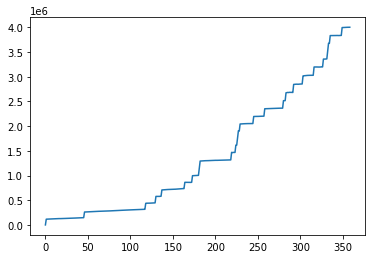

In [51]:
plt.plot(PnL)

# Buy + model Regression

In [52]:
pool = pd.DataFrame()
pool.index = stock.index
pool['SP1'] = stock['SP1']
pool['BP1'] = stock['BP1']
pool['askPrice1'] = future['askPrice1']
pool['bidPrice1'] = future['bidPrice1']
pool['spread'] = spread['spread']
pool.index = pd.to_datetime(pool.index)

In [53]:
trade = pd.DataFrame()
trade.index = pool.index
trade['spread'] = pool['spread']
trade['signal'] = 0
trade['cap'] = 0
trade['pnl'] = 0
trade.index = pd.to_datetime(trade.index)

In [54]:
day_list = np.unique(pool.index.date)
train_period = 3
PnL = np.array([0])

for i in tqdm(range(len(day_list) - train_period)[-30:]):
    train_start_time = trade.index >= pd.to_datetime(str(day_list[i]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period - 1]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train = trade[train_start_time & train_end_time]
    test_start_time = trade.index >= pd.to_datetime(str(day_list[i + train_period]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test = trade[test_start_time & test_end_time]

    feature_train = feature[train_start_time & train_end_time]
    feature_test = feature[test_start_time & test_end_time]

    current_pool = pool[test_start_time & test_end_time]

    mean = np.mean(train['spread'])
    std = np.std(train['spread'])

    upper = mean + 1.5 * std
    lower = mean - 1.5 * std

    X_train = feature_train[feature_train.columns[0:-1]]
    y_train = feature_train['delta_spread']
    upper_quantile=0.85
    lower_quantile=0.15
    train_spread_upper = float(y_train.quantile(upper_quantile))
    train_spread_lower = float(y_train.quantile(lower_quantile))

    model_ols = LinearRegression()
    model_ols.fit(X_train, y_train)
    
    X_test = feature_test[feature_test.columns[0:-1]]
    y_test = feature_test['delta_spread']

    y_test_pred = model_ols.predict(X_test)

    for tick_idx in (range(len(test.index))): 
        current_data = test[0:tick_idx + 1]
        
        if tick_idx != len(test.index) - 2:
            # long spread
            if test.loc[test.index[tick_idx]]['spread'] <= lower: 
                if np.sum(current_data['signal']) == 0: 
                    if y_test_pred[tick_idx] < train_spread_lower:
                        test.at[test.index[tick_idx+1], 'signal'] = 1
                        test.at[test.index[tick_idx+1], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                    else: 
                        test.at[test.index[tick_idx], 'signal'] = 1
                        test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']

            # back to mean
            elif test.loc[test.index[tick_idx]]['spread'] >= mean: 
                if np.sum(current_data['signal']) == 1: 
                    if y_test_pred[tick_idx] > train_spread_upper:
                        test.at[test.index[tick_idx+1], 'signal'] = -1
                        test.at[test.index[tick_idx+1], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                        test.at[test.index[tick_idx+1], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
                    else:
                        test.at[test.index[tick_idx], 'signal'] = -1
                        test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                        test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']

            # short spread
            elif test.loc[test.index[tick_idx]]['spread'] >= upper: 
                if np.sum(current_data['signal']) == 0: 
                    if y_test_pred[tick_idx] > train_spread_upper:
                        test.at[test.index[tick_idx+1], 'signal'] = -1
                        test.at[test.index[tick_idx+1], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                    else: 
                        test.at[test.index[tick_idx], 'signal'] = -1
                        test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']

            # back to mean 
            elif test.loc[test.index[tick_idx]]['spread'] <= mean: 
                if np.sum(current_data['signal']) == -1: 
                    if y_test_pred[tick_idx] < train_spread_lower:
                        test.at[test.index[tick_idx+1], 'signal'] = 1
                        test.at[test.index[tick_idx+1], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                        test.at[test.index[tick_idx+1], 'pnl'] = np.sum(current_data['cap'])# + trade.loc[test.index[tick_idx]]['cap']
                    else: 
                        test.at[test.index[tick_idx], 'signal'] = 1
                        test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                        test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap'])# + trade.loc[test.index[tick_idx]]['cap']

            else: 
                pass
        
        else:
            pass
            #if np.sum(current_data['signal']) == 1: 
            #    test.at[test.index[tick_idx], 'signal'] = -1
            #    test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
            #    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            #elif np.sum(current_data['signal']) == -1: 
            #    test.at[test.index[tick_idx], 'signal'] = 1
            #    test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
            #    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            #else:
            #    pass
    
    
    PnL = np.append(PnL, test[test['pnl'] != 0]['pnl'] + PnL[-1])

100%|██████████| 30/30 [02:33<00:00,  5.13s/it]


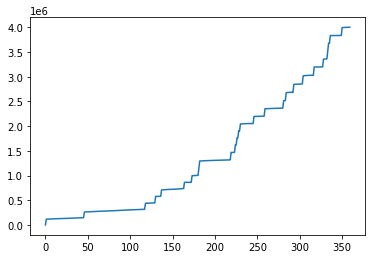

In [55]:
plt.plot(PnL)

# Buy + model LGBM

In [57]:
pool = pd.DataFrame()
pool.index = stock.index
pool['SP1'] = stock['SP1']
pool['BP1'] = stock['BP1']
pool['askPrice1'] = future['askPrice1']
pool['bidPrice1'] = future['bidPrice1']
pool['spread'] = spread['spread']
pool.index = pd.to_datetime(pool.index)

In [58]:
trade = pd.DataFrame()
trade.index = pool.index
trade['spread'] = pool['spread']
trade['signal'] = 0
trade['cap'] = 0
trade['pnl'] = 0
trade.index = pd.to_datetime(trade.index)

In [59]:
day_list = np.unique(pool.index.date)
train_period = 3
PnL = np.array([0])

for i in tqdm(range(len(day_list) - train_period)[-30:]):
    train_start_time = trade.index >= pd.to_datetime(str(day_list[i]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period - 1]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train = trade[train_start_time & train_end_time]
    test_start_time = trade.index >= pd.to_datetime(str(day_list[i + train_period]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test = trade[test_start_time & test_end_time]

    feature_train = feature[train_start_time & train_end_time]
    feature_test = feature[test_start_time & test_end_time]

    current_pool = pool[test_start_time & test_end_time]

    mean = np.mean(train['spread'])
    std = np.std(train['spread'])

    upper = mean + 1.5 * std
    lower = mean - 1.5 * std

    X_train = feature_train[feature_train.columns[0:-1]]
    y_train = feature_train['delta_spread']
    upper_quantile=0.85
    lower_quantile=0.15
    train_spread_upper = float(y_train.quantile(upper_quantile))
    train_spread_lower = float(y_train.quantile(lower_quantile))

    X_test = feature_test[feature_test.columns[0:-1]]
    y_test = feature_test['delta_spread']


    gbm = lgb.LGBMRegressor(objective='regression',num_leaves=31,learning_rate=0.1,n_estimators=50)
    gbm.fit(X_train, y_train,eval_set=[(X_test, y_test)],eval_metric='l1',early_stopping_rounds=5)

    y_test_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

    for tick_idx in (range(len(test.index))): 
        current_data = test[0:tick_idx + 1]
        
        if tick_idx != len(test.index) - 2:
            # long spread
            if test.loc[test.index[tick_idx]]['spread'] <= lower: 
                if np.sum(current_data['signal']) == 0: 
                    if y_test_pred[tick_idx] < train_spread_lower:
                        test.at[test.index[tick_idx+1], 'signal'] = 1
                        test.at[test.index[tick_idx+1], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                    else: 
                        test.at[test.index[tick_idx], 'signal'] = 1
                        test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']

            # back to mean
            elif test.loc[test.index[tick_idx]]['spread'] >= mean: 
                if np.sum(current_data['signal']) == 1: 
                    if y_test_pred[tick_idx] > train_spread_upper:
                        test.at[test.index[tick_idx+1], 'signal'] = -1
                        test.at[test.index[tick_idx+1], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                        test.at[test.index[tick_idx+1], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
                    else:
                        test.at[test.index[tick_idx], 'signal'] = -1
                        test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                        test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']

            # short spread
            elif test.loc[test.index[tick_idx]]['spread'] >= upper: 
                if np.sum(current_data['signal']) == 0: 
                    if y_test_pred[tick_idx] > train_spread_upper:
                        test.at[test.index[tick_idx+1], 'signal'] = -1
                        test.at[test.index[tick_idx+1], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                    else: 
                        test.at[test.index[tick_idx], 'signal'] = -1
                        test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']

            # back to mean 
            elif test.loc[test.index[tick_idx]]['spread'] <= mean: 
                if np.sum(current_data['signal']) == -1: 
                    if y_test_pred[tick_idx] < train_spread_lower:
                        test.at[test.index[tick_idx+1], 'signal'] = 1
                        test.at[test.index[tick_idx+1], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                        test.at[test.index[tick_idx+1], 'pnl'] = np.sum(current_data['cap'])# + trade.loc[test.index[tick_idx]]['cap']
                    else: 
                        test.at[test.index[tick_idx], 'signal'] = 1
                        test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                        test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap'])# + trade.loc[test.index[tick_idx]]['cap']

            else: 
                pass
        
        else:
            pass
            #if np.sum(current_data['signal']) == 1: 
            #    test.at[test.index[tick_idx], 'signal'] = -1
            #    test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
            #    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            #elif np.sum(current_data['signal']) == -1: 
            #    test.at[test.index[tick_idx], 'signal'] = 1
            #    test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
            #    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            #else:
            #    pass
    
    
    PnL = np.append(PnL, test[test['pnl'] != 0]['pnl'] + PnL[-1])

  0%|          | 0/30 [00:00<?, ?it/s]

[1]	valid_0's l1: 4.33933e-05	valid_0's l2: 1.12148e-07
[2]	valid_0's l1: 3.94643e-05	valid_0's l2: 9.31897e-08
[3]	valid_0's l1: 3.60204e-05	valid_0's l2: 7.81676e-08
[4]	valid_0's l1: 3.27869e-05	valid_0's l2: 6.54437e-08
[5]	valid_0's l1: 2.99161e-05	valid_0's l2: 5.53793e-08
[6]	valid_0's l1: 2.73899e-05	valid_0's l2: 4.74596e-08
[7]	valid_0's l1: 2.51433e-05	valid_0's l2: 4.11464e-08
[8]	valid_0's l1: 2.30479e-05	valid_0's l2: 3.57892e-08
[9]	valid_0's l1: 2.12101e-05	valid_0's l2: 3.15428e-08
[10]	valid_0's l1: 1.95199e-05	valid_0's l2: 2.80344e-08
[11]	valid_0's l1: 1.80009e-05	valid_0's l2: 2.50406e-08
[12]	valid_0's l1: 1.66534e-05	valid_0's l2: 2.27396e-08
[13]	valid_0's l1: 1.53739e-05	valid_0's l2: 2.07059e-08
[14]	valid_0's l1: 1.42436e-05	valid_0's l2: 1.9176e-08
[15]	valid_0's l1: 1.31894e-05	valid_0's l2: 1.78381e-08
[16]	valid_0's l1: 1.23627e-05	valid_0's l2: 1.7027e-08
[17]	valid_0's l1: 1.15244e-05	valid_0's l2: 1.61248e-08
[18]	valid_0's l1: 1.07822e-05	valid_0's l

  3%|▎         | 1/30 [00:05<02:41,  5.56s/it]

[1]	valid_0's l1: 5.30474e-05	valid_0's l2: 1.4224e-07
[2]	valid_0's l1: 4.78703e-05	valid_0's l2: 1.16018e-07
[3]	valid_0's l1: 4.31975e-05	valid_0's l2: 9.45107e-08
[4]	valid_0's l1: 3.9069e-05	valid_0's l2: 7.74568e-08
[5]	valid_0's l1: 3.531e-05	valid_0's l2: 6.33674e-08
[6]	valid_0's l1: 3.19178e-05	valid_0's l2: 5.20225e-08
[7]	valid_0's l1: 2.88557e-05	valid_0's l2: 4.2679e-08
[8]	valid_0's l1: 2.61839e-05	valid_0's l2: 3.5143e-08
[9]	valid_0's l1: 2.37371e-05	valid_0's l2: 2.9125e-08
[10]	valid_0's l1: 2.15958e-05	valid_0's l2: 2.41932e-08
[11]	valid_0's l1: 1.97337e-05	valid_0's l2: 2.03354e-08
[12]	valid_0's l1: 1.78814e-05	valid_0's l2: 1.70014e-08
[13]	valid_0's l1: 1.6272e-05	valid_0's l2: 1.42755e-08
[14]	valid_0's l1: 1.47812e-05	valid_0's l2: 1.20394e-08
[15]	valid_0's l1: 1.33584e-05	valid_0's l2: 1.01496e-08
[16]	valid_0's l1: 1.2108e-05	valid_0's l2: 8.61824e-09
[17]	valid_0's l1: 1.10085e-05	valid_0's l2: 7.41271e-09
[18]	valid_0's l1: 9.94937e-06	valid_0's l2: 6.38

  7%|▋         | 2/30 [00:10<02:20,  5.03s/it]

[1]	valid_0's l1: 7.14417e-05	valid_0's l2: 1.81929e-07
[2]	valid_0's l1: 6.53077e-05	valid_0's l2: 1.52108e-07
[3]	valid_0's l1: 5.93694e-05	valid_0's l2: 1.2655e-07
[4]	valid_0's l1: 5.42795e-05	valid_0's l2: 1.07292e-07
[5]	valid_0's l1: 5.04776e-05	valid_0's l2: 9.46355e-08
[6]	valid_0's l1: 4.70982e-05	valid_0's l2: 8.50695e-08
[7]	valid_0's l1: 4.31552e-05	valid_0's l2: 7.22843e-08
[8]	valid_0's l1: 4.0707e-05	valid_0's l2: 6.5706e-08
[9]	valid_0's l1: 3.88017e-05	valid_0's l2: 6.14755e-08
[10]	valid_0's l1: 3.62414e-05	valid_0's l2: 5.49279e-08
[11]	valid_0's l1: 3.44485e-05	valid_0's l2: 5.18476e-08
[12]	valid_0's l1: 3.28095e-05	valid_0's l2: 4.90582e-08
[13]	valid_0's l1: 3.13365e-05	valid_0's l2: 4.73816e-08
[14]	valid_0's l1: 2.94163e-05	valid_0's l2: 4.35289e-08
[15]	valid_0's l1: 2.82033e-05	valid_0's l2: 4.256e-08
[16]	valid_0's l1: 2.72888e-05	valid_0's l2: 4.21359e-08
[17]	valid_0's l1: 2.62168e-05	valid_0's l2: 4.15033e-08
[18]	valid_0's l1: 2.52428e-05	valid_0's l2: 

 10%|█         | 3/30 [00:16<02:31,  5.61s/it]

[1]	valid_0's l1: 7.11989e-05	valid_0's l2: 1.75437e-07
[2]	valid_0's l1: 6.43109e-05	valid_0's l2: 1.44616e-07
[3]	valid_0's l1: 5.80328e-05	valid_0's l2: 1.20194e-07
[4]	valid_0's l1: 5.21997e-05	valid_0's l2: 1.00669e-07
[5]	valid_0's l1: 4.68481e-05	valid_0's l2: 8.46488e-08
[6]	valid_0's l1: 4.19279e-05	valid_0's l2: 7.2485e-08
[7]	valid_0's l1: 3.90648e-05	valid_0's l2: 6.33428e-08
[8]	valid_0's l1: 3.68339e-05	valid_0's l2: 5.64739e-08
[9]	valid_0's l1: 3.46438e-05	valid_0's l2: 5.0947e-08
[10]	valid_0's l1: 3.29356e-05	valid_0's l2: 4.69907e-08
[11]	valid_0's l1: 3.12535e-05	valid_0's l2: 4.37897e-08
[12]	valid_0's l1: 2.97097e-05	valid_0's l2: 4.15277e-08
[13]	valid_0's l1: 2.84833e-05	valid_0's l2: 3.9966e-08
[14]	valid_0's l1: 2.72873e-05	valid_0's l2: 3.90916e-08
[15]	valid_0's l1: 2.62774e-05	valid_0's l2: 3.83175e-08
[16]	valid_0's l1: 2.52392e-05	valid_0's l2: 3.78487e-08
[17]	valid_0's l1: 2.44984e-05	valid_0's l2: 3.78249e-08
[18]	valid_0's l1: 2.3707e-05	valid_0's l2:

 13%|█▎        | 4/30 [00:24<02:49,  6.51s/it]

[1]	valid_0's l1: 8.8058e-05	valid_0's l2: 2.03072e-07
[2]	valid_0's l1: 7.94521e-05	valid_0's l2: 1.65678e-07
[3]	valid_0's l1: 7.20323e-05	valid_0's l2: 1.37067e-07
[4]	valid_0's l1: 6.51065e-05	valid_0's l2: 1.13512e-07
[5]	valid_0's l1: 5.92502e-05	valid_0's l2: 9.61044e-08
[6]	valid_0's l1: 5.40099e-05	valid_0's l2: 8.12883e-08
[7]	valid_0's l1: 4.96627e-05	valid_0's l2: 6.97306e-08
[8]	valid_0's l1: 4.57718e-05	valid_0's l2: 6.07176e-08
[9]	valid_0's l1: 4.22464e-05	valid_0's l2: 5.33765e-08
[10]	valid_0's l1: 3.91437e-05	valid_0's l2: 4.78481e-08
[11]	valid_0's l1: 3.62561e-05	valid_0's l2: 4.32899e-08
[12]	valid_0's l1: 3.35859e-05	valid_0's l2: 3.96643e-08
[13]	valid_0's l1: 3.11594e-05	valid_0's l2: 3.66631e-08
[14]	valid_0's l1: 2.89306e-05	valid_0's l2: 3.45004e-08
[15]	valid_0's l1: 2.69575e-05	valid_0's l2: 3.3114e-08
[16]	valid_0's l1: 2.53441e-05	valid_0's l2: 3.1865e-08
[17]	valid_0's l1: 2.42605e-05	valid_0's l2: 3.12172e-08
[18]	valid_0's l1: 2.33082e-05	valid_0's l2

 17%|█▋        | 5/30 [00:31<02:50,  6.84s/it]

[1]	valid_0's l1: 6.58497e-05	valid_0's l2: 1.49304e-07
[2]	valid_0's l1: 5.989e-05	valid_0's l2: 1.23865e-07
[3]	valid_0's l1: 5.47288e-05	valid_0's l2: 1.04118e-07
[4]	valid_0's l1: 4.99165e-05	valid_0's l2: 8.76965e-08
[5]	valid_0's l1: 4.55699e-05	valid_0's l2: 7.44529e-08
[6]	valid_0's l1: 4.172e-05	valid_0's l2: 6.40657e-08
[7]	valid_0's l1: 3.8168e-05	valid_0's l2: 5.54175e-08
[8]	valid_0's l1: 3.50064e-05	valid_0's l2: 4.87397e-08
[9]	valid_0's l1: 3.19811e-05	valid_0's l2: 4.2839e-08
[10]	valid_0's l1: 2.94276e-05	valid_0's l2: 3.84989e-08
[11]	valid_0's l1: 2.7415e-05	valid_0's l2: 3.51613e-08
[12]	valid_0's l1: 2.53122e-05	valid_0's l2: 3.23062e-08
[13]	valid_0's l1: 2.3343e-05	valid_0's l2: 2.93482e-08
[14]	valid_0's l1: 2.17091e-05	valid_0's l2: 2.70935e-08
[15]	valid_0's l1: 2.03461e-05	valid_0's l2: 2.52734e-08
[16]	valid_0's l1: 1.89638e-05	valid_0's l2: 2.38625e-08
[17]	valid_0's l1: 1.77336e-05	valid_0's l2: 2.26445e-08
[18]	valid_0's l1: 1.65505e-05	valid_0's l2: 2.1

 20%|██        | 6/30 [00:39<02:50,  7.09s/it]

[1]	valid_0's l1: 5.87157e-05	valid_0's l2: 1.35134e-07
[2]	valid_0's l1: 5.32774e-05	valid_0's l2: 1.11561e-07
[3]	valid_0's l1: 4.844e-05	valid_0's l2: 9.25914e-08
[4]	valid_0's l1: 4.39995e-05	valid_0's l2: 7.68878e-08
[5]	valid_0's l1: 4.00358e-05	valid_0's l2: 6.42248e-08
[6]	valid_0's l1: 3.64548e-05	valid_0's l2: 5.39179e-08
[7]	valid_0's l1: 3.32629e-05	valid_0's l2: 4.56495e-08
[8]	valid_0's l1: 3.0383e-05	valid_0's l2: 3.88213e-08
[9]	valid_0's l1: 2.76796e-05	valid_0's l2: 3.30397e-08
[10]	valid_0's l1: 2.53551e-05	valid_0's l2: 2.86261e-08
[11]	valid_0's l1: 2.31729e-05	valid_0's l2: 2.46716e-08
[12]	valid_0's l1: 2.13019e-05	valid_0's l2: 2.17118e-08
[13]	valid_0's l1: 1.95157e-05	valid_0's l2: 1.91468e-08
[14]	valid_0's l1: 1.79208e-05	valid_0's l2: 1.70503e-08
[15]	valid_0's l1: 1.64921e-05	valid_0's l2: 1.53144e-08
[16]	valid_0's l1: 1.52187e-05	valid_0's l2: 1.38422e-08
[17]	valid_0's l1: 1.41168e-05	valid_0's l2: 1.27788e-08
[18]	valid_0's l1: 1.30222e-05	valid_0's l2

 23%|██▎       | 7/30 [00:45<02:39,  6.92s/it]

[1]	valid_0's l1: 0.000108333	valid_0's l2: 2.38752e-07
[2]	valid_0's l1: 9.7118e-05	valid_0's l2: 1.96509e-07
[3]	valid_0's l1: 8.71067e-05	valid_0's l2: 1.64483e-07
[4]	valid_0's l1: 7.7915e-05	valid_0's l2: 1.39698e-07
[5]	valid_0's l1: 6.97756e-05	valid_0's l2: 1.21605e-07
[6]	valid_0's l1: 6.2417e-05	valid_0's l2: 1.07648e-07
[7]	valid_0's l1: 6.00688e-05	valid_0's l2: 9.82312e-08
[8]	valid_0's l1: 5.79611e-05	valid_0's l2: 9.0691e-08
[9]	valid_0's l1: 5.64361e-05	valid_0's l2: 8.64516e-08
[10]	valid_0's l1: 5.47626e-05	valid_0's l2: 8.31971e-08
[11]	valid_0's l1: 5.35333e-05	valid_0's l2: 8.17994e-08
[12]	valid_0's l1: 5.22814e-05	valid_0's l2: 8.10309e-08
[13]	valid_0's l1: 5.1296e-05	valid_0's l2: 8.17097e-08
[14]	valid_0's l1: 5.02334e-05	valid_0's l2: 8.17438e-08
[15]	valid_0's l1: 4.93009e-05	valid_0's l2: 8.2638e-08
[16]	valid_0's l1: 4.83793e-05	valid_0's l2: 8.31373e-08
[17]	valid_0's l1: 4.72322e-05	valid_0's l2: 8.30817e-08


 27%|██▋       | 8/30 [00:49<02:11,  5.96s/it]

[1]	valid_0's l1: 8.11956e-05	valid_0's l2: 1.81186e-07
[2]	valid_0's l1: 7.2326e-05	valid_0's l2: 1.47629e-07
[3]	valid_0's l1: 6.48209e-05	valid_0's l2: 1.2269e-07
[4]	valid_0's l1: 5.79151e-05	valid_0's l2: 1.03505e-07
[5]	valid_0's l1: 5.12199e-05	valid_0's l2: 8.75746e-08
[6]	valid_0's l1: 4.629e-05	valid_0's l2: 7.59941e-08
[7]	valid_0's l1: 4.36968e-05	valid_0's l2: 6.69781e-08
[8]	valid_0's l1: 4.19826e-05	valid_0's l2: 6.13234e-08
[9]	valid_0's l1: 4.03345e-05	valid_0's l2: 5.66593e-08
[10]	valid_0's l1: 3.8784e-05	valid_0's l2: 5.33911e-08
[11]	valid_0's l1: 3.70995e-05	valid_0's l2: 5.08054e-08
[12]	valid_0's l1: 3.60557e-05	valid_0's l2: 4.95761e-08
[13]	valid_0's l1: 3.51045e-05	valid_0's l2: 4.9038e-08
[14]	valid_0's l1: 3.40206e-05	valid_0's l2: 4.84801e-08
[15]	valid_0's l1: 3.31154e-05	valid_0's l2: 4.86382e-08
[16]	valid_0's l1: 3.27665e-05	valid_0's l2: 4.95508e-08
[17]	valid_0's l1: 3.22199e-05	valid_0's l2: 5.0189e-08
[18]	valid_0's l1: 3.21778e-05	valid_0's l2: 5.

 30%|███       | 9/30 [00:57<02:18,  6.62s/it]

[1]	valid_0's l1: 8.9291e-05	valid_0's l2: 1.76102e-07
[2]	valid_0's l1: 8.00663e-05	valid_0's l2: 1.42509e-07
[3]	valid_0's l1: 7.16934e-05	valid_0's l2: 1.15845e-07
[4]	valid_0's l1: 6.41471e-05	valid_0's l2: 9.48744e-08
[5]	valid_0's l1: 5.72689e-05	valid_0's l2: 7.82468e-08
[6]	valid_0's l1: 5.1435e-05	valid_0's l2: 6.60217e-08
[7]	valid_0's l1: 4.68748e-05	valid_0's l2: 5.59061e-08
[8]	valid_0's l1: 4.29901e-05	valid_0's l2: 4.82319e-08
[9]	valid_0's l1: 3.94362e-05	valid_0's l2: 4.21331e-08
[10]	valid_0's l1: 3.642e-05	valid_0's l2: 3.77572e-08
[11]	valid_0's l1: 3.37012e-05	valid_0's l2: 3.42989e-08
[12]	valid_0's l1: 3.12338e-05	valid_0's l2: 3.16093e-08
[13]	valid_0's l1: 2.87588e-05	valid_0's l2: 2.92554e-08
[14]	valid_0's l1: 2.66198e-05	valid_0's l2: 2.74947e-08
[15]	valid_0's l1: 2.50317e-05	valid_0's l2: 2.69505e-08
[16]	valid_0's l1: 2.35579e-05	valid_0's l2: 2.6078e-08
[17]	valid_0's l1: 2.20668e-05	valid_0's l2: 2.52687e-08
[18]	valid_0's l1: 2.07611e-05	valid_0's l2: 

 33%|███▎      | 10/30 [01:06<02:24,  7.22s/it]

[1]	valid_0's l1: 0.000131574	valid_0's l2: 2.52358e-07
[2]	valid_0's l1: 0.000119811	valid_0's l2: 2.093e-07
[3]	valid_0's l1: 0.000109127	valid_0's l2: 1.74446e-07
[4]	valid_0's l1: 9.9391e-05	valid_0's l2: 1.46032e-07
[5]	valid_0's l1: 9.03884e-05	valid_0's l2: 1.22327e-07
[6]	valid_0's l1: 8.26118e-05	valid_0's l2: 1.03988e-07
[7]	valid_0's l1: 7.52824e-05	valid_0's l2: 8.85775e-08
[8]	valid_0's l1: 6.88067e-05	valid_0's l2: 7.61396e-08
[9]	valid_0's l1: 6.29343e-05	valid_0's l2: 6.6277e-08
[10]	valid_0's l1: 5.7727e-05	valid_0's l2: 5.85476e-08
[11]	valid_0's l1: 5.31373e-05	valid_0's l2: 5.24947e-08
[12]	valid_0's l1: 4.89305e-05	valid_0's l2: 4.73031e-08
[13]	valid_0's l1: 4.4966e-05	valid_0's l2: 4.26291e-08
[14]	valid_0's l1: 4.14408e-05	valid_0's l2: 3.89374e-08
[15]	valid_0's l1: 3.82777e-05	valid_0's l2: 3.58365e-08
[16]	valid_0's l1: 3.52635e-05	valid_0's l2: 3.33639e-08
[17]	valid_0's l1: 3.27114e-05	valid_0's l2: 3.1456e-08
[18]	valid_0's l1: 3.055e-05	valid_0's l2: 2.99

 37%|███▋      | 11/30 [01:10<01:58,  6.21s/it]

[1]	valid_0's l1: 8.03995e-05	valid_0's l2: 1.70082e-07
[2]	valid_0's l1: 7.32866e-05	valid_0's l2: 1.41502e-07
[3]	valid_0's l1: 6.68766e-05	valid_0's l2: 1.18589e-07
[4]	valid_0's l1: 6.10913e-05	valid_0's l2: 1.00255e-07
[5]	valid_0's l1: 5.57698e-05	valid_0's l2: 8.48694e-08
[6]	valid_0's l1: 5.09369e-05	valid_0's l2: 7.23801e-08
[7]	valid_0's l1: 4.6796e-05	valid_0's l2: 6.30863e-08
[8]	valid_0's l1: 4.31138e-05	valid_0's l2: 5.55735e-08
[9]	valid_0's l1: 3.97603e-05	valid_0's l2: 4.9294e-08
[10]	valid_0's l1: 3.68254e-05	valid_0's l2: 4.46381e-08
[11]	valid_0's l1: 3.41257e-05	valid_0's l2: 4.07996e-08
[12]	valid_0's l1: 3.16851e-05	valid_0's l2: 3.77279e-08
[13]	valid_0's l1: 2.94805e-05	valid_0's l2: 3.55145e-08
[14]	valid_0's l1: 2.74349e-05	valid_0's l2: 3.35066e-08
[15]	valid_0's l1: 2.55248e-05	valid_0's l2: 3.15469e-08
[16]	valid_0's l1: 2.37839e-05	valid_0's l2: 2.98593e-08
[17]	valid_0's l1: 2.22235e-05	valid_0's l2: 2.86464e-08
[18]	valid_0's l1: 2.07713e-05	valid_0's l

 40%|████      | 12/30 [01:14<01:42,  5.68s/it]

[1]	valid_0's l1: 0.000193066	valid_0's l2: 4.08543e-07
[2]	valid_0's l1: 0.000181104	valid_0's l2: 3.57817e-07
[3]	valid_0's l1: 0.000170091	valid_0's l2: 3.17016e-07
[4]	valid_0's l1: 0.000159845	valid_0's l2: 2.83713e-07
[5]	valid_0's l1: 0.000151041	valid_0's l2: 2.58748e-07
[6]	valid_0's l1: 0.000142894	valid_0's l2: 2.38993e-07
[7]	valid_0's l1: 0.000135839	valid_0's l2: 2.22737e-07
[8]	valid_0's l1: 0.000129818	valid_0's l2: 2.08374e-07
[9]	valid_0's l1: 0.000124524	valid_0's l2: 1.97295e-07
[10]	valid_0's l1: 0.000119455	valid_0's l2: 1.88101e-07
[11]	valid_0's l1: 0.000114885	valid_0's l2: 1.80587e-07
[12]	valid_0's l1: 0.000110625	valid_0's l2: 1.73589e-07
[13]	valid_0's l1: 0.000106817	valid_0's l2: 1.68084e-07
[14]	valid_0's l1: 0.00010349	valid_0's l2: 1.64243e-07
[15]	valid_0's l1: 0.000100636	valid_0's l2: 1.61135e-07
[16]	valid_0's l1: 9.81796e-05	valid_0's l2: 1.60438e-07
[17]	valid_0's l1: 9.52342e-05	valid_0's l2: 1.57234e-07
[18]	valid_0's l1: 9.34121e-05	valid_0's 

 43%|████▎     | 13/30 [01:15<01:12,  4.25s/it]

[1]	valid_0's l1: 8.87926e-05	valid_0's l2: 1.77254e-07
[2]	valid_0's l1: 8.18375e-05	valid_0's l2: 1.51744e-07
[3]	valid_0's l1: 7.5613e-05	valid_0's l2: 1.3144e-07
[4]	valid_0's l1: 6.97772e-05	valid_0's l2: 1.13707e-07
[5]	valid_0's l1: 6.48133e-05	valid_0's l2: 9.99831e-08
[6]	valid_0's l1: 6.0393e-05	valid_0's l2: 8.91419e-08
[7]	valid_0's l1: 5.60717e-05	valid_0's l2: 7.9138e-08
[8]	valid_0's l1: 5.25158e-05	valid_0's l2: 7.19198e-08
[9]	valid_0's l1: 4.90463e-05	valid_0's l2: 6.53724e-08
[10]	valid_0's l1: 4.60941e-05	valid_0's l2: 6.04783e-08
[11]	valid_0's l1: 4.31749e-05	valid_0's l2: 5.58114e-08
[12]	valid_0's l1: 4.07691e-05	valid_0's l2: 5.25972e-08
[13]	valid_0's l1: 3.8413e-05	valid_0's l2: 4.94191e-08
[14]	valid_0's l1: 3.66387e-05	valid_0's l2: 4.68775e-08
[15]	valid_0's l1: 3.46185e-05	valid_0's l2: 4.46378e-08
[16]	valid_0's l1: 3.30021e-05	valid_0's l2: 4.3307e-08
[17]	valid_0's l1: 3.17928e-05	valid_0's l2: 4.22761e-08
[18]	valid_0's l1: 3.00736e-05	valid_0's l2: 4

 47%|████▋     | 14/30 [01:21<01:14,  4.63s/it]

[1]	valid_0's l1: 0.000104402	valid_0's l2: 2.14663e-07
[2]	valid_0's l1: 9.59518e-05	valid_0's l2: 1.8124e-07
[3]	valid_0's l1: 8.85249e-05	valid_0's l2: 1.54574e-07
[4]	valid_0's l1: 8.13374e-05	valid_0's l2: 1.31353e-07
[5]	valid_0's l1: 7.53092e-05	valid_0's l2: 1.13648e-07
[6]	valid_0's l1: 6.95428e-05	valid_0's l2: 9.83452e-08
[7]	valid_0's l1: 6.43384e-05	valid_0's l2: 8.58543e-08
[8]	valid_0's l1: 5.96784e-05	valid_0's l2: 7.53155e-08
[9]	valid_0's l1: 5.55287e-05	valid_0's l2: 6.69903e-08
[10]	valid_0's l1: 5.15481e-05	valid_0's l2: 5.97736e-08
[11]	valid_0's l1: 4.80873e-05	valid_0's l2: 5.40437e-08
[12]	valid_0's l1: 4.4999e-05	valid_0's l2: 4.92322e-08
[13]	valid_0's l1: 4.21764e-05	valid_0's l2: 4.52575e-08
[14]	valid_0's l1: 4.06611e-05	valid_0's l2: 4.27453e-08
[15]	valid_0's l1: 3.8441e-05	valid_0's l2: 3.98805e-08
[16]	valid_0's l1: 3.7065e-05	valid_0's l2: 3.79812e-08
[17]	valid_0's l1: 3.53196e-05	valid_0's l2: 3.60753e-08
[18]	valid_0's l1: 3.42409e-05	valid_0's l2:

 50%|█████     | 15/30 [01:26<01:11,  4.75s/it]

[1]	valid_0's l1: 9.55951e-05	valid_0's l2: 2.00594e-07
[2]	valid_0's l1: 8.80324e-05	valid_0's l2: 1.69662e-07
[3]	valid_0's l1: 8.12435e-05	valid_0's l2: 1.44639e-07
[4]	valid_0's l1: 7.5318e-05	valid_0's l2: 1.24793e-07
[5]	valid_0's l1: 6.97167e-05	valid_0's l2: 1.07872e-07
[6]	valid_0's l1: 6.47226e-05	valid_0's l2: 9.42596e-08
[7]	valid_0's l1: 6.0107e-05	valid_0's l2: 8.27554e-08
[8]	valid_0's l1: 5.59193e-05	valid_0's l2: 7.30621e-08
[9]	valid_0's l1: 5.21319e-05	valid_0's l2: 6.51258e-08
[10]	valid_0's l1: 4.87966e-05	valid_0's l2: 5.88778e-08
[11]	valid_0's l1: 4.57936e-05	valid_0's l2: 5.36959e-08
[12]	valid_0's l1: 4.30127e-05	valid_0's l2: 4.91507e-08
[13]	valid_0's l1: 4.06458e-05	valid_0's l2: 4.56586e-08
[14]	valid_0's l1: 3.83965e-05	valid_0's l2: 4.2744e-08
[15]	valid_0's l1: 3.61638e-05	valid_0's l2: 3.9588e-08
[16]	valid_0's l1: 3.42862e-05	valid_0's l2: 3.74384e-08
[17]	valid_0's l1: 3.2408e-05	valid_0's l2: 3.49602e-08
[18]	valid_0's l1: 3.08802e-05	valid_0's l2: 

 53%|█████▎    | 16/30 [01:32<01:13,  5.23s/it]

[1]	valid_0's l1: 9.41169e-05	valid_0's l2: 1.84892e-07
[2]	valid_0's l1: 8.57565e-05	valid_0's l2: 1.53771e-07
[3]	valid_0's l1: 7.84467e-05	valid_0's l2: 1.29015e-07
[4]	valid_0's l1: 7.2054e-05	valid_0's l2: 1.09398e-07
[5]	valid_0's l1: 6.63367e-05	valid_0's l2: 9.35905e-08
[6]	valid_0's l1: 6.10208e-05	valid_0's l2: 8.01841e-08
[7]	valid_0's l1: 5.62472e-05	valid_0's l2: 6.93472e-08
[8]	valid_0's l1: 5.1775e-05	valid_0's l2: 6.01159e-08
[9]	valid_0's l1: 4.80323e-05	valid_0's l2: 5.29022e-08
[10]	valid_0's l1: 4.45551e-05	valid_0's l2: 4.69252e-08
[11]	valid_0's l1: 4.13309e-05	valid_0's l2: 4.17196e-08
[12]	valid_0's l1: 3.83999e-05	valid_0's l2: 3.74782e-08
[13]	valid_0's l1: 3.56416e-05	valid_0's l2: 3.38993e-08
[14]	valid_0's l1: 3.32521e-05	valid_0's l2: 3.07985e-08
[15]	valid_0's l1: 3.09649e-05	valid_0's l2: 2.82138e-08
[16]	valid_0's l1: 2.95277e-05	valid_0's l2: 2.65904e-08
[17]	valid_0's l1: 2.76633e-05	valid_0's l2: 2.47809e-08
[18]	valid_0's l1: 2.58991e-05	valid_0's l

 57%|█████▋    | 17/30 [01:37<01:05,  5.06s/it]

[1]	valid_0's l1: 8.37713e-05	valid_0's l2: 1.68785e-07
[2]	valid_0's l1: 7.63799e-05	valid_0's l2: 1.40354e-07
[3]	valid_0's l1: 6.96093e-05	valid_0's l2: 1.16976e-07
[4]	valid_0's l1: 6.36459e-05	valid_0's l2: 9.84924e-08
[5]	valid_0's l1: 5.82667e-05	valid_0's l2: 8.341e-08
[6]	valid_0's l1: 5.31813e-05	valid_0's l2: 7.03073e-08
[7]	valid_0's l1: 4.87825e-05	valid_0's l2: 6.01874e-08
[8]	valid_0's l1: 4.48954e-05	valid_0's l2: 5.21034e-08
[9]	valid_0's l1: 4.11255e-05	valid_0's l2: 4.49425e-08
[10]	valid_0's l1: 3.76744e-05	valid_0's l2: 3.90487e-08
[11]	valid_0's l1: 3.46337e-05	valid_0's l2: 3.43595e-08
[12]	valid_0's l1: 3.2688e-05	valid_0's l2: 3.11293e-08
[13]	valid_0's l1: 3.03079e-05	valid_0's l2: 2.81032e-08
[14]	valid_0's l1: 2.81168e-05	valid_0's l2: 2.55978e-08
[15]	valid_0's l1: 2.59934e-05	valid_0's l2: 2.34403e-08
[16]	valid_0's l1: 2.41178e-05	valid_0's l2: 2.15024e-08
[17]	valid_0's l1: 2.29826e-05	valid_0's l2: 2.0142e-08
[18]	valid_0's l1: 2.14534e-05	valid_0's l2:

 60%|██████    | 18/30 [01:42<01:00,  5.06s/it]

[1]	valid_0's l1: 6.07603e-05	valid_0's l2: 1.28149e-07
[2]	valid_0's l1: 5.43908e-05	valid_0's l2: 1.0352e-07
[3]	valid_0's l1: 4.87228e-05	valid_0's l2: 8.41824e-08
[4]	valid_0's l1: 4.35869e-05	valid_0's l2: 6.88693e-08
[5]	valid_0's l1: 3.89242e-05	valid_0's l2: 5.67507e-08
[6]	valid_0's l1: 3.4971e-05	valid_0's l2: 4.74899e-08
[7]	valid_0's l1: 3.20525e-05	valid_0's l2: 3.99576e-08
[8]	valid_0's l1: 2.93679e-05	valid_0's l2: 3.4043e-08
[9]	valid_0's l1: 2.69499e-05	valid_0's l2: 2.92433e-08
[10]	valid_0's l1: 2.47085e-05	valid_0's l2: 2.5409e-08
[11]	valid_0's l1: 2.30032e-05	valid_0's l2: 2.27849e-08
[12]	valid_0's l1: 2.18423e-05	valid_0's l2: 2.1333e-08
[13]	valid_0's l1: 2.03983e-05	valid_0's l2: 1.97497e-08
[14]	valid_0's l1: 1.9157e-05	valid_0's l2: 1.86135e-08
[15]	valid_0's l1: 1.79237e-05	valid_0's l2: 1.76826e-08
[16]	valid_0's l1: 1.71138e-05	valid_0's l2: 1.71703e-08
[17]	valid_0's l1: 1.61237e-05	valid_0's l2: 1.66233e-08
[18]	valid_0's l1: 1.53066e-05	valid_0's l2: 1

 63%|██████▎   | 19/30 [01:50<01:04,  5.82s/it]

[1]	valid_0's l1: 7.27233e-05	valid_0's l2: 1.53271e-07
[2]	valid_0's l1: 6.64184e-05	valid_0's l2: 1.27584e-07
[3]	valid_0's l1: 6.06084e-05	valid_0's l2: 1.06527e-07
[4]	valid_0's l1: 5.54621e-05	valid_0's l2: 8.99672e-08
[5]	valid_0's l1: 5.07382e-05	valid_0's l2: 7.63299e-08
[6]	valid_0's l1: 4.66648e-05	valid_0's l2: 6.58827e-08
[7]	valid_0's l1: 4.28647e-05	valid_0's l2: 5.68149e-08
[8]	valid_0's l1: 3.94179e-05	valid_0's l2: 4.96795e-08
[9]	valid_0's l1: 3.63566e-05	valid_0's l2: 4.41054e-08
[10]	valid_0's l1: 3.36352e-05	valid_0's l2: 3.97631e-08
[11]	valid_0's l1: 3.11536e-05	valid_0's l2: 3.62077e-08
[12]	valid_0's l1: 2.88578e-05	valid_0's l2: 3.33823e-08
[13]	valid_0's l1: 2.72973e-05	valid_0's l2: 3.13219e-08
[14]	valid_0's l1: 2.59762e-05	valid_0's l2: 2.96122e-08
[15]	valid_0's l1: 2.44094e-05	valid_0's l2: 2.82193e-08
[16]	valid_0's l1: 2.29973e-05	valid_0's l2: 2.70878e-08
[17]	valid_0's l1: 2.16618e-05	valid_0's l2: 2.61587e-08
[18]	valid_0's l1: 2.07442e-05	valid_0's

 67%|██████▋   | 20/30 [01:54<00:55,  5.55s/it]

[1]	valid_0's l1: 0.000113162	valid_0's l2: 2.15883e-07
[2]	valid_0's l1: 0.000102781	valid_0's l2: 1.81094e-07
[3]	valid_0's l1: 9.33108e-05	valid_0's l2: 1.53609e-07
[4]	valid_0's l1: 8.48659e-05	valid_0's l2: 1.3252e-07
[5]	valid_0's l1: 7.71705e-05	valid_0's l2: 1.16354e-07
[6]	valid_0's l1: 7.05211e-05	valid_0's l2: 1.04259e-07
[7]	valid_0's l1: 6.60072e-05	valid_0's l2: 9.45555e-08
[8]	valid_0's l1: 6.22512e-05	valid_0's l2: 8.74092e-08
[9]	valid_0's l1: 5.83371e-05	valid_0's l2: 7.98491e-08
[10]	valid_0's l1: 5.53605e-05	valid_0's l2: 7.61396e-08
[11]	valid_0's l1: 5.23133e-05	valid_0's l2: 7.20889e-08
[12]	valid_0's l1: 4.98446e-05	valid_0's l2: 7.04642e-08
[13]	valid_0's l1: 4.72382e-05	valid_0's l2: 6.81489e-08
[14]	valid_0's l1: 4.51686e-05	valid_0's l2: 6.77045e-08
[15]	valid_0's l1: 4.29956e-05	valid_0's l2: 6.63108e-08
[16]	valid_0's l1: 4.16995e-05	valid_0's l2: 6.68031e-08
[17]	valid_0's l1: 4.07187e-05	valid_0's l2: 6.67264e-08
[18]	valid_0's l1: 3.96058e-05	valid_0's 

 70%|███████   | 21/30 [02:01<00:53,  5.94s/it]

[1]	valid_0's l1: 6.18082e-05	valid_0's l2: 1.11011e-07
[2]	valid_0's l1: 5.61267e-05	valid_0's l2: 9.12081e-08
[3]	valid_0's l1: 5.08523e-05	valid_0's l2: 7.48179e-08
[4]	valid_0's l1: 4.64013e-05	valid_0's l2: 6.25064e-08
[5]	valid_0's l1: 4.22401e-05	valid_0's l2: 5.22088e-08
[6]	valid_0's l1: 3.8557e-05	valid_0's l2: 4.40063e-08
[7]	valid_0's l1: 3.51731e-05	valid_0's l2: 3.72575e-08
[8]	valid_0's l1: 3.21171e-05	valid_0's l2: 3.18443e-08
[9]	valid_0's l1: 2.93848e-05	valid_0's l2: 2.7405e-08
[10]	valid_0's l1: 2.68657e-05	valid_0's l2: 2.36711e-08
[11]	valid_0's l1: 2.46471e-05	valid_0's l2: 2.07799e-08
[12]	valid_0's l1: 2.26284e-05	valid_0's l2: 1.84272e-08
[13]	valid_0's l1: 2.07429e-05	valid_0's l2: 1.64155e-08
[14]	valid_0's l1: 1.89574e-05	valid_0's l2: 1.46313e-08
[15]	valid_0's l1: 1.78094e-05	valid_0's l2: 1.36073e-08
[16]	valid_0's l1: 1.67673e-05	valid_0's l2: 1.2671e-08
[17]	valid_0's l1: 1.5377e-05	valid_0's l2: 1.16175e-08
[18]	valid_0's l1: 1.41661e-05	valid_0's l2:

 73%|███████▎  | 22/30 [02:06<00:44,  5.53s/it]

[1]	valid_0's l1: 7.71516e-05	valid_0's l2: 1.43784e-07
[2]	valid_0's l1: 7.00358e-05	valid_0's l2: 1.18343e-07
[3]	valid_0's l1: 6.37859e-05	valid_0's l2: 9.81116e-08
[4]	valid_0's l1: 5.81469e-05	valid_0's l2: 8.16832e-08
[5]	valid_0's l1: 5.31229e-05	valid_0's l2: 6.86076e-08
[6]	valid_0's l1: 4.85011e-05	valid_0's l2: 5.78693e-08
[7]	valid_0's l1: 4.44177e-05	valid_0's l2: 4.92604e-08
[8]	valid_0's l1: 4.05646e-05	valid_0's l2: 4.20314e-08
[9]	valid_0's l1: 3.70304e-05	valid_0's l2: 3.59257e-08
[10]	valid_0's l1: 3.38905e-05	valid_0's l2: 3.11308e-08
[11]	valid_0's l1: 3.1082e-05	valid_0's l2: 2.7292e-08
[12]	valid_0's l1: 2.85029e-05	valid_0's l2: 2.40295e-08
[13]	valid_0's l1: 2.61959e-05	valid_0's l2: 2.13871e-08
[14]	valid_0's l1: 2.42108e-05	valid_0's l2: 1.92554e-08
[15]	valid_0's l1: 2.23834e-05	valid_0's l2: 1.75885e-08
[16]	valid_0's l1: 2.07272e-05	valid_0's l2: 1.61878e-08
[17]	valid_0's l1: 1.91695e-05	valid_0's l2: 1.50655e-08
[18]	valid_0's l1: 1.81408e-05	valid_0's l

 77%|███████▋  | 23/30 [02:11<00:38,  5.43s/it]

[1]	valid_0's l1: 7.92888e-05	valid_0's l2: 1.45789e-07
[2]	valid_0's l1: 7.22452e-05	valid_0's l2: 1.20657e-07
[3]	valid_0's l1: 6.59501e-05	valid_0's l2: 1.00543e-07
[4]	valid_0's l1: 6.01783e-05	valid_0's l2: 8.40684e-08
[5]	valid_0's l1: 5.4825e-05	valid_0's l2: 7.0297e-08
[6]	valid_0's l1: 4.99735e-05	valid_0's l2: 5.90819e-08
[7]	valid_0's l1: 4.57785e-05	valid_0's l2: 5.02438e-08
[8]	valid_0's l1: 4.20772e-05	valid_0's l2: 4.32008e-08
[9]	valid_0's l1: 3.86207e-05	valid_0's l2: 3.73897e-08
[10]	valid_0's l1: 3.55984e-05	valid_0's l2: 3.28331e-08
[11]	valid_0's l1: 3.27037e-05	valid_0's l2: 2.8784e-08
[12]	valid_0's l1: 3.00361e-05	valid_0's l2: 2.5413e-08
[13]	valid_0's l1: 2.76508e-05	valid_0's l2: 2.27624e-08
[14]	valid_0's l1: 2.54636e-05	valid_0's l2: 2.06208e-08
[15]	valid_0's l1: 2.35556e-05	valid_0's l2: 1.89376e-08
[16]	valid_0's l1: 2.18335e-05	valid_0's l2: 1.75771e-08
[17]	valid_0's l1: 2.04704e-05	valid_0's l2: 1.64204e-08
[18]	valid_0's l1: 1.93105e-05	valid_0's l2:

 80%|████████  | 24/30 [02:16<00:31,  5.19s/it]

[1]	valid_0's l1: 7.23004e-05	valid_0's l2: 1.31812e-07
[2]	valid_0's l1: 6.64416e-05	valid_0's l2: 1.10986e-07
[3]	valid_0's l1: 6.103e-05	valid_0's l2: 9.37952e-08
[4]	valid_0's l1: 5.6062e-05	valid_0's l2: 7.95544e-08
[5]	valid_0's l1: 5.18317e-05	valid_0's l2: 6.85372e-08
[6]	valid_0's l1: 4.78987e-05	valid_0's l2: 5.92479e-08
[7]	valid_0's l1: 4.43646e-05	valid_0's l2: 5.16916e-08
[8]	valid_0's l1: 4.11492e-05	valid_0's l2: 4.54132e-08
[9]	valid_0's l1: 3.81789e-05	valid_0's l2: 4.0067e-08
[10]	valid_0's l1: 3.56853e-05	valid_0's l2: 3.59314e-08
[11]	valid_0's l1: 3.3263e-05	valid_0's l2: 3.2292e-08
[12]	valid_0's l1: 3.10835e-05	valid_0's l2: 2.91582e-08
[13]	valid_0's l1: 2.90995e-05	valid_0's l2: 2.65719e-08
[14]	valid_0's l1: 2.7312e-05	valid_0's l2: 2.45226e-08
[15]	valid_0's l1: 2.56643e-05	valid_0's l2: 2.28087e-08
[16]	valid_0's l1: 2.43056e-05	valid_0's l2: 2.14578e-08
[17]	valid_0's l1: 2.29097e-05	valid_0's l2: 2.02579e-08
[18]	valid_0's l1: 2.17496e-05	valid_0's l2: 1.

 83%|████████▎ | 25/30 [02:20<00:25,  5.02s/it]

[1]	valid_0's l1: 0.000108192	valid_0's l2: 2.06003e-07
[2]	valid_0's l1: 0.000102929	valid_0's l2: 1.86231e-07
[3]	valid_0's l1: 9.82091e-05	valid_0's l2: 1.7142e-07
[4]	valid_0's l1: 9.39629e-05	valid_0's l2: 1.60347e-07
[5]	valid_0's l1: 9.01221e-05	valid_0's l2: 1.52189e-07
[6]	valid_0's l1: 8.66024e-05	valid_0's l2: 1.46203e-07
[7]	valid_0's l1: 8.34906e-05	valid_0's l2: 1.42207e-07
[8]	valid_0's l1: 8.06332e-05	valid_0's l2: 1.39293e-07
[9]	valid_0's l1: 7.81169e-05	valid_0's l2: 1.37635e-07
[10]	valid_0's l1: 7.58358e-05	valid_0's l2: 1.36682e-07
[11]	valid_0's l1: 7.37526e-05	valid_0's l2: 1.36396e-07
[12]	valid_0's l1: 7.18963e-05	valid_0's l2: 1.36499e-07
[13]	valid_0's l1: 7.02346e-05	valid_0's l2: 1.36994e-07
[14]	valid_0's l1: 6.8689e-05	valid_0's l2: 1.37683e-07
[15]	valid_0's l1: 6.74264e-05	valid_0's l2: 1.38706e-07
[16]	valid_0's l1: 6.57724e-05	valid_0's l2: 1.37153e-07


 87%|████████▋ | 26/30 [02:26<00:20,  5.07s/it]

[1]	valid_0's l1: 0.000100157	valid_0's l2: 2.03613e-07
[2]	valid_0's l1: 9.40099e-05	valid_0's l2: 1.78736e-07
[3]	valid_0's l1: 8.84372e-05	valid_0's l2: 1.58992e-07
[4]	valid_0's l1: 8.34976e-05	valid_0's l2: 1.43798e-07
[5]	valid_0's l1: 7.88879e-05	valid_0's l2: 1.31216e-07
[6]	valid_0's l1: 7.47866e-05	valid_0's l2: 1.21541e-07
[7]	valid_0's l1: 7.11038e-05	valid_0's l2: 1.141e-07
[8]	valid_0's l1: 6.79292e-05	valid_0's l2: 1.08224e-07
[9]	valid_0's l1: 6.50166e-05	valid_0's l2: 1.03714e-07
[10]	valid_0's l1: 6.23955e-05	valid_0's l2: 1.00306e-07
[11]	valid_0's l1: 6.00286e-05	valid_0's l2: 9.78205e-08
[12]	valid_0's l1: 5.7952e-05	valid_0's l2: 9.61937e-08
[13]	valid_0's l1: 5.60091e-05	valid_0's l2: 9.48742e-08
[14]	valid_0's l1: 5.42707e-05	valid_0's l2: 9.40793e-08
[15]	valid_0's l1: 5.2958e-05	valid_0's l2: 9.3908e-08
[16]	valid_0's l1: 5.14923e-05	valid_0's l2: 9.36577e-08
[17]	valid_0's l1: 5.03088e-05	valid_0's l2: 9.35644e-08
[18]	valid_0's l1: 4.9098e-05	valid_0's l2: 9

 90%|█████████ | 27/30 [02:30<00:14,  4.88s/it]

[1]	valid_0's l1: 0.000109011	valid_0's l2: 2.21993e-07
[2]	valid_0's l1: 9.99182e-05	valid_0's l2: 1.86735e-07
[3]	valid_0's l1: 9.15267e-05	valid_0's l2: 1.56856e-07
[4]	valid_0's l1: 8.39703e-05	valid_0's l2: 1.32935e-07
[5]	valid_0's l1: 7.71643e-05	valid_0's l2: 1.12925e-07
[6]	valid_0's l1: 7.10308e-05	valid_0's l2: 9.66971e-08
[7]	valid_0's l1: 6.60778e-05	valid_0's l2: 8.44236e-08
[8]	valid_0's l1: 6.17427e-05	valid_0's l2: 7.48756e-08
[9]	valid_0's l1: 5.78659e-05	valid_0's l2: 6.73084e-08
[10]	valid_0's l1: 5.43826e-05	valid_0's l2: 6.12508e-08
[11]	valid_0's l1: 5.06242e-05	valid_0's l2: 5.47458e-08
[12]	valid_0's l1: 4.7244e-05	valid_0's l2: 4.92661e-08
[13]	valid_0's l1: 4.46125e-05	valid_0's l2: 4.59791e-08
[14]	valid_0's l1: 4.17698e-05	valid_0's l2: 4.20827e-08
[15]	valid_0's l1: 3.96118e-05	valid_0's l2: 3.99203e-08
[16]	valid_0's l1: 3.72951e-05	valid_0's l2: 3.71004e-08
[17]	valid_0's l1: 3.52045e-05	valid_0's l2: 3.48136e-08
[18]	valid_0's l1: 3.37986e-05	valid_0's 

 93%|█████████▎| 28/30 [02:35<00:10,  5.04s/it]

[1]	valid_0's l1: 0.000104598	valid_0's l2: 2.05394e-07
[2]	valid_0's l1: 9.56603e-05	valid_0's l2: 1.7174e-07
[3]	valid_0's l1: 8.75824e-05	valid_0's l2: 1.44312e-07
[4]	valid_0's l1: 8.07922e-05	valid_0's l2: 1.22239e-07
[5]	valid_0's l1: 7.45423e-05	valid_0's l2: 1.04358e-07
[6]	valid_0's l1: 6.87524e-05	valid_0's l2: 8.94543e-08
[7]	valid_0's l1: 6.3738e-05	valid_0's l2: 7.79387e-08
[8]	valid_0's l1: 5.87036e-05	valid_0's l2: 6.72123e-08
[9]	valid_0's l1: 5.42227e-05	valid_0's l2: 5.85836e-08
[10]	valid_0's l1: 5.04374e-05	valid_0's l2: 5.21644e-08
[11]	valid_0's l1: 4.71548e-05	valid_0's l2: 4.69063e-08
[12]	valid_0's l1: 4.40864e-05	valid_0's l2: 4.27325e-08
[13]	valid_0's l1: 4.16414e-05	valid_0's l2: 3.9508e-08
[14]	valid_0's l1: 3.90892e-05	valid_0's l2: 3.64451e-08
[15]	valid_0's l1: 3.65015e-05	valid_0's l2: 3.34331e-08
[16]	valid_0's l1: 3.41322e-05	valid_0's l2: 3.09382e-08
[17]	valid_0's l1: 3.23801e-05	valid_0's l2: 2.91483e-08
[18]	valid_0's l1: 3.11333e-05	valid_0's l2

 97%|█████████▋| 29/30 [02:40<00:04,  4.89s/it]

[1]	valid_0's l1: 9.94969e-05	valid_0's l2: 1.79301e-07
[2]	valid_0's l1: 9.06705e-05	valid_0's l2: 1.48772e-07
[3]	valid_0's l1: 8.31143e-05	valid_0's l2: 1.24699e-07
[4]	valid_0's l1: 7.59922e-05	valid_0's l2: 1.04647e-07
[5]	valid_0's l1: 7.02924e-05	valid_0's l2: 8.96164e-08
[6]	valid_0's l1: 6.43554e-05	valid_0's l2: 7.56865e-08
[7]	valid_0's l1: 5.88903e-05	valid_0's l2: 6.38406e-08
[8]	valid_0's l1: 5.40422e-05	valid_0's l2: 5.45736e-08
[9]	valid_0's l1: 4.99333e-05	valid_0's l2: 4.73804e-08
[10]	valid_0's l1: 4.67013e-05	valid_0's l2: 4.21446e-08
[11]	valid_0's l1: 4.31009e-05	valid_0's l2: 3.6973e-08
[12]	valid_0's l1: 4.02243e-05	valid_0's l2: 3.3051e-08
[13]	valid_0's l1: 3.7253e-05	valid_0's l2: 2.94712e-08
[14]	valid_0's l1: 3.49527e-05	valid_0's l2: 2.68868e-08
[15]	valid_0's l1: 3.24226e-05	valid_0's l2: 2.43981e-08
[16]	valid_0's l1: 3.01101e-05	valid_0's l2: 2.22362e-08
[17]	valid_0's l1: 2.83789e-05	valid_0's l2: 2.08636e-08
[18]	valid_0's l1: 2.70999e-05	valid_0's l2

100%|██████████| 30/30 [02:44<00:00,  5.47s/it]


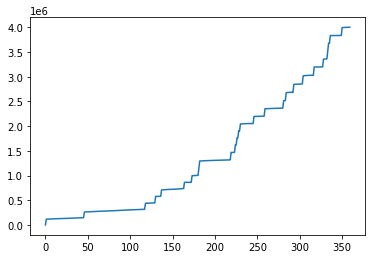

In [60]:
plt.plot(PnL)

other pair

In [63]:
futureCode = futureCodeList[4]
stockCode = stockCodeList[4]

stock = pd.read_csv(data_clean_path + futureCode + "-" + stockCode + "/stock.csv.gz", compression='gzip', index_col=0)
future = pd.read_csv(data_clean_path + futureCode + "-" + stockCode + "/future.csv.gz", compression='gzip', index_col=0)
spread = np.log(stock['price']) - np.log(future['midQ'])
spread = pd.DataFrame(spread)
spread.columns = ['spread']
feature = pd.read_csv(factor_path + futureCode + "-" + stockCode + "/factor.csv.gz", compression='gzip', index_col=0)

pool = pd.DataFrame()
pool.index = stock.index
pool['SP1'] = stock['SP1']
pool['BP1'] = stock['BP1']
pool['askPrice1'] = future['askPrice1']
pool['bidPrice1'] = future['bidPrice1']
pool['spread'] = spread['spread']
pool.index = pd.to_datetime(pool.index)

trade = pd.DataFrame()
trade.index = pool.index
trade['spread'] = pool['spread']
trade['signal'] = 0
trade['cap'] = 0
trade['pnl'] = 0
trade.index = pd.to_datetime(trade.index)

In [64]:
day_list = np.unique(pool.index.date)
train_period = 3
PnL = np.array([0])

for i in tqdm(range(len(day_list) - train_period)[-30:]):
    train_start_time = trade.index >= pd.to_datetime(str(day_list[i]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period - 1]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train = trade[train_start_time & train_end_time]
    test_start_time = trade.index >= pd.to_datetime(str(day_list[i + train_period]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test = trade[test_start_time & test_end_time]

    feature_train = feature[train_start_time & train_end_time]
    feature_test = feature[test_start_time & test_end_time]

    current_pool = pool[test_start_time & test_end_time]

    mean = np.mean(train['spread'])
    std = np.std(train['spread'])

    upper = mean + 1.5 * std
    lower = mean - 1.5 * std

    X_train = feature_train[feature_train.columns[0:-1]]
    y_train = feature_train['delta_spread']
    upper_quantile=0.85
    lower_quantile=0.15
    train_spread_upper = float(y_train.quantile(upper_quantile))
    train_spread_lower = float(y_train.quantile(lower_quantile))

    model_ols = LinearRegression()
    model_ols.fit(X_train, y_train)
    
    X_test = feature_test[feature_test.columns[0:-1]]
    y_test = feature_test['delta_spread']

    y_test_pred = model_ols.predict(X_test)

    for tick_idx in (range(len(test.index))): 
        current_data = test[0:tick_idx + 1]
        
        if tick_idx != len(test.index) - 2:
            # long spread
            if test.loc[test.index[tick_idx]]['spread'] <= lower: 
                if np.sum(current_data['signal']) == 0: 
                    if y_test_pred[tick_idx] < train_spread_lower:
                        test.at[test.index[tick_idx+1], 'signal'] = 1
                        test.at[test.index[tick_idx+1], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                    else: 
                        test.at[test.index[tick_idx], 'signal'] = 1
                        test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']

            # back to mean
            elif test.loc[test.index[tick_idx]]['spread'] >= mean: 
                if np.sum(current_data['signal']) == 1: 
                    if y_test_pred[tick_idx] > train_spread_upper:
                        test.at[test.index[tick_idx+1], 'signal'] = -1
                        test.at[test.index[tick_idx+1], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                        test.at[test.index[tick_idx+1], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
                    else:
                        test.at[test.index[tick_idx], 'signal'] = -1
                        test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                        test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']

            # short spread
            elif test.loc[test.index[tick_idx]]['spread'] >= upper: 
                if np.sum(current_data['signal']) == 0: 
                    if y_test_pred[tick_idx] > train_spread_upper:
                        test.at[test.index[tick_idx+1], 'signal'] = -1
                        test.at[test.index[tick_idx+1], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                    else: 
                        test.at[test.index[tick_idx], 'signal'] = -1
                        test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']

            # back to mean 
            elif test.loc[test.index[tick_idx]]['spread'] <= mean: 
                if np.sum(current_data['signal']) == -1: 
                    if y_test_pred[tick_idx] < train_spread_lower:
                        test.at[test.index[tick_idx+1], 'signal'] = 1
                        test.at[test.index[tick_idx+1], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                        test.at[test.index[tick_idx+1], 'pnl'] = np.sum(current_data['cap'])# + trade.loc[test.index[tick_idx]]['cap']
                    else: 
                        test.at[test.index[tick_idx], 'signal'] = 1
                        test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                        test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap'])# + trade.loc[test.index[tick_idx]]['cap']

            else: 
                pass
        
        else:
            pass
            #if np.sum(current_data['signal']) == 1: 
            #    test.at[test.index[tick_idx], 'signal'] = -1
            #    test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
            #    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            #elif np.sum(current_data['signal']) == -1: 
            #    test.at[test.index[tick_idx], 'signal'] = 1
            #    test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
            #    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            #else:
            #    pass
    
    
    PnL = np.append(PnL, test[test['pnl'] != 0]['pnl'] + PnL[-1])

100%|██████████| 30/30 [01:08<00:00,  2.27s/it]


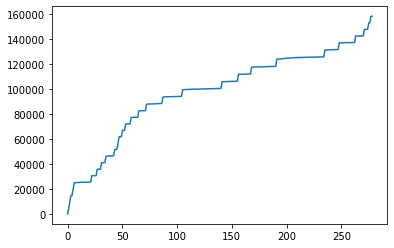

In [65]:
plt.plot(PnL)

pair 3

In [66]:
futureCode = futureCodeList[2]
stockCode = stockCodeList[2]

stock = pd.read_csv(data_clean_path + futureCode + "-" + stockCode + "/stock.csv.gz", compression='gzip', index_col=0)
future = pd.read_csv(data_clean_path + futureCode + "-" + stockCode + "/future.csv.gz", compression='gzip', index_col=0)
spread = np.log(stock['price']) - np.log(future['midQ'])
spread = pd.DataFrame(spread)
spread.columns = ['spread']
feature = pd.read_csv(factor_path + futureCode + "-" + stockCode + "/factor.csv.gz", compression='gzip', index_col=0)

pool = pd.DataFrame()
pool.index = stock.index
pool['SP1'] = stock['SP1']
pool['BP1'] = stock['BP1']
pool['askPrice1'] = future['askPrice1']
pool['bidPrice1'] = future['bidPrice1']
pool['spread'] = spread['spread']
pool.index = pd.to_datetime(pool.index)

trade = pd.DataFrame()
trade.index = pool.index
trade['spread'] = pool['spread']
trade['signal'] = 0
trade['cap'] = 0
trade['pnl'] = 0
trade.index = pd.to_datetime(trade.index)

100%|██████████| 30/30 [01:47<00:00,  3.57s/it]


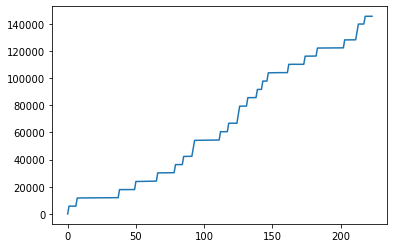

In [67]:
day_list = np.unique(pool.index.date)
train_period = 3
PnL = np.array([0])

for i in tqdm(range(len(day_list) - train_period)[-30:]):
    train_start_time = trade.index >= pd.to_datetime(str(day_list[i]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period - 1]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train = trade[train_start_time & train_end_time]
    test_start_time = trade.index >= pd.to_datetime(str(day_list[i + train_period]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test = trade[test_start_time & test_end_time]

    feature_train = feature[train_start_time & train_end_time]
    feature_test = feature[test_start_time & test_end_time]

    current_pool = pool[test_start_time & test_end_time]

    mean = np.mean(train['spread'])
    std = np.std(train['spread'])

    upper = mean + 1.5 * std
    lower = mean - 1.5 * std

    X_train = feature_train[feature_train.columns[0:-1]]
    y_train = feature_train['delta_spread']
    upper_quantile=0.85
    lower_quantile=0.15
    train_spread_upper = float(y_train.quantile(upper_quantile))
    train_spread_lower = float(y_train.quantile(lower_quantile))

    model_ols = LinearRegression()
    model_ols.fit(X_train, y_train)
    
    X_test = feature_test[feature_test.columns[0:-1]]
    y_test = feature_test['delta_spread']

    y_test_pred = model_ols.predict(X_test)

    for tick_idx in (range(len(test.index))): 
        current_data = test[0:tick_idx + 1]
        
        if tick_idx != len(test.index) - 2:
            # long spread
            if test.loc[test.index[tick_idx]]['spread'] <= lower: 
                if np.sum(current_data['signal']) == 0: 
                    if y_test_pred[tick_idx] < train_spread_lower:
                        test.at[test.index[tick_idx+1], 'signal'] = 1
                        test.at[test.index[tick_idx+1], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                    else: 
                        test.at[test.index[tick_idx], 'signal'] = 1
                        test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']

            # back to mean
            elif test.loc[test.index[tick_idx]]['spread'] >= mean: 
                if np.sum(current_data['signal']) == 1: 
                    if y_test_pred[tick_idx] > train_spread_upper:
                        test.at[test.index[tick_idx+1], 'signal'] = -1
                        test.at[test.index[tick_idx+1], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                        test.at[test.index[tick_idx+1], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
                    else:
                        test.at[test.index[tick_idx], 'signal'] = -1
                        test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                        test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']

            # short spread
            elif test.loc[test.index[tick_idx]]['spread'] >= upper: 
                if np.sum(current_data['signal']) == 0: 
                    if y_test_pred[tick_idx] > train_spread_upper:
                        test.at[test.index[tick_idx+1], 'signal'] = -1
                        test.at[test.index[tick_idx+1], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                    else: 
                        test.at[test.index[tick_idx], 'signal'] = -1
                        test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']

            # back to mean 
            elif test.loc[test.index[tick_idx]]['spread'] <= mean: 
                if np.sum(current_data['signal']) == -1: 
                    if y_test_pred[tick_idx] < train_spread_lower:
                        test.at[test.index[tick_idx+1], 'signal'] = 1
                        test.at[test.index[tick_idx+1], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                        test.at[test.index[tick_idx+1], 'pnl'] = np.sum(current_data['cap'])# + trade.loc[test.index[tick_idx]]['cap']
                    else: 
                        test.at[test.index[tick_idx], 'signal'] = 1
                        test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                        test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap'])# + trade.loc[test.index[tick_idx]]['cap']

            else: 
                pass
        
        else:
            pass
            #if np.sum(current_data['signal']) == 1: 
            #    test.at[test.index[tick_idx], 'signal'] = -1
            #    test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
            #    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            #elif np.sum(current_data['signal']) == -1: 
            #    test.at[test.index[tick_idx], 'signal'] = 1
            #    test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
            #    test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            #else:
            #    pass
    
    
    PnL = np.append(PnL, test[test['pnl'] != 0]['pnl'] + PnL[-1])
plt.plot(PnL)